In [1]:
from tqdm import tqdm, trange
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import scipy as sp
import time
import sys
import importlib
import os
import hashlib
import subprocess
import gc

from IPython import display
from IPython.display import clear_output
import copy
from copy import deepcopy
# from sklearn.metrics import roc_auc_score, roc_curve

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset

# from captum.attr import IntegratedGradients
# from captum.attr import LayerConductance
# from captum.attr import NeuronConductance

try:
    import cPickle as pickle
except:
    import pickle
    
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

code_folder1="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/"
code_folder2=f"{code_folder1}/prediction_step_0/"

import sys
sys.path.append(code_folder1)
sys.path.append(code_folder2)


energy_folder="/home/energy/ykhalak/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF/"
energy_folder_workstation="/netmount/energy/ykhalak/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF/"
all_ligs_db_file_energy=f"{energy_folder_workstation}/full_ligs.pickle"


all_ligs_db_file_old="/home/ykhalak/Projects/ML_dG/pde2_dG/how_do_ligs_fit_in_pocket/adaptive_learning_test_from_morphed_structs/../processed_ligs_w_morphing_sim_annealing_only_sucessfull.pickle"
experiment_folder="/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF/"
all_ligs_db_file=f"{experiment_folder}/full_ligs.pickle"

datafolder=f"{experiment_folder}/cached_reprs"

# settings_folder=f"{experiment_folder}/combined_repr_search_with_repeats_and_mparam_scan/settings/"
# os.makedirs(settings_folder, exist_ok=True)


Bohr2Ang=0.529177249
RT=0.001985875*300 #kcal/mol


# Import training code

In [2]:
if 'custom_dataset_modular_with_binning_6EZF' in sys.modules:
    importlib.reload(sys.modules['custom_dataset_modular_with_binning_6EZF'])
else:
    import custom_dataset_modular_with_binning_6EZF
from custom_dataset_modular_with_binning_6EZF import dataBlocks, CustomMolModularDataset

if 'owl_trainer_w_params_general_with_ensemble_summary_model_6EZF' in sys.modules:
    importlib.reload(sys.modules['owl_trainer_w_params_general_with_ensemble_summary_model_6EZF'])
else:
    import owl_trainer_w_params_general_with_ensemble_summary_model_6EZF
from owl_trainer_w_params_general_with_ensemble_summary_model_6EZF import *

# Define representation blocks

In [3]:
flags_2D=[dataBlocks.MACCS, dataBlocks.Descriptors, dataBlocks.Graph_desc, dataBlocks.BCUT2D]
flags_3D=[dataBlocks.EState_FP, dataBlocks.Pharmacophore_feature_map,
          dataBlocks.MOE, dataBlocks.MQN, dataBlocks.GETAWAY, dataBlocks.AUTOCORR2D,
          dataBlocks.AUTOCORR3D, dataBlocks.WHIM, dataBlocks.RDF,
          dataBlocks.USR, dataBlocks.USRCUT, dataBlocks.PEOE_VSA, dataBlocks.SMR_VSA,
          dataBlocks.SlogP_VSA, dataBlocks.MORSE]

flags_2D_3D=flags_2D+flags_3D

# Prep folder structure

In [ ]:
## soft link the ligand database
#! ln -s $all_ligs_db_file_old $all_ligs_db_file

# add a dG property to every ligand and save in experiment folder
with open(all_ligs_db_file_old, 'rb') as f:
    ligs_expt = pickle.load(f)
    
for lig in ligs_expt:
    lig.SetProp( "dG", str(-RT*float(lig.GetProp('[V] hPDE2_pIC50'))*np.log(10)) )
pickle.dump( ligs_expt, open( all_ligs_db_file, "wb" ) )

del ligs_expt
_=gc.collect()

In [ ]:
# make a copy of database on energy
os.makedirs(energy_folder_workstation, exist_ok=True)
!cp $all_ligs_db_file_old $all_ligs_db_file_energy

## Cache representations

In [ ]:
representations=[]
representation_names=[]

block_names_full=["2D_3D", "PLEC_filtered", "MDenerg", "MDenerg_long_cut", "MDenerg_binned", "MDenerg_long_cut_binned", "atom_hot", "atom_hot_surf"]
# import itertools
# l = [False, True]
# combs=list(itertools.product(l, repeat=len(block_names_full)))
# # print(len(combs))
# #raise()
combs=np.eye(len(block_names_full), dtype=bool)

for c in combs:
    b_2D_3D, b_PLEC_filt, b_MDenerg, b_MDenerg_lc, b_MDenerg_binned, b_MDenerg_lc_binned, b_ah, b_ah_vdw = c
#     if np.count_nonzero(c)==0:
#         continue # skip the case with no active reperesenations
        
#     if(b_ah and b_ah_vdw):
#         continue # skip if both atom hot forms are active

    representation_flags=[0]*len(dataBlocks)
    
#     nMDenerg_repr=0
#     nah_repr=0
#     ntot_repr=0
    
    if(b_2D_3D):
        for b in flags_2D:
            representation_flags[int(b)]=1
        for b in flags_3D:
            representation_flags[int(b)]=1
#         ntot_repr+=1
    if(b_PLEC_filt):
        representation_flags[int(dataBlocks.PLEC_filtered)]=1
#         ntot_repr+=1
    if(b_MDenerg):
        representation_flags[int(dataBlocks.MDenerg)]=1
#         nMDenerg_repr+=1
#         ntot_repr+=1
    if(b_MDenerg_lc):
        representation_flags[int(dataBlocks.MDenerg_longcut)]=1
#         nMDenerg_repr+=1
#         ntot_repr+=1
    if(b_MDenerg_binned):
        representation_flags[int(dataBlocks.MDenerg_binned)]=1
#         nMDenerg_repr+=1
#         ntot_repr+=1
    if(b_MDenerg_lc_binned):
        representation_flags[int(dataBlocks.MDenerg_longcut_binned)]=1
#         nMDenerg_repr+=1
#         ntot_repr+=1
    if(b_ah):
        representation_flags[int(dataBlocks.atom_hot)]=1
#         nah_repr+=1
#         ntot_repr+=1
    if(b_ah_vdw):
        representation_flags[int(dataBlocks.atom_hot_on_vdw_surf)]=1
#         nah_repr+=1
#         ntot_repr+=1
        
#     if(nMDenerg_repr>1 or nah_repr>1):
#         continue
#     if(ntot_repr>1):
#         continue

    dr_name=""
    for i in range(len(c)):
        if c[i]:
            dr_name+=block_names_full[i]+'_'
    dr_name=dr_name[:-1]
    
    
    representations.append(representation_flags)
    representation_names.append(dr_name)
    
print(len(representations))
print(representation_names)

In [ ]:
with open(all_ligs_db_file, 'rb') as f:
    ligs_expt = pickle.load(f)
print("Number of experimental ligands:", len(ligs_expt))

In [ ]:
for k in range(len(representations)):
    representation_flags=representations[k]
    dr_name=representation_names[k]
    
    DS=CustomMolModularDataset(ligs=ligs_expt,
                               representation_flags=representation_flags,
                               normalize_x=True, use_cache=True, use_combined_cache=True, use_hdf5_cache=False,
                               datafolder=datafolder, internal_cache_maxMem_MB=0,
                               morphes_sim_an_folder="/home/ykhalak/Projects/ML_dG/pde2_dG/how_do_ligs_fit_in_pocket/morphes_sim_an/"
                              )
    print(f"{dr_name} width:\t{DS[0][0].shape}", flush=True)
    
    debug_generator = torch.utils.data.DataLoader(DS, shuffle=False, batch_size=20)
    pbar=tqdm(total=len(DS), position=0, leave=True)
    for local_batch, local_labels in debug_generator:
        pbar.update(local_batch.shape[0])
    pbar.close()
    
    del DS, debug_generator
    _=gc.collect()
    

# Embed ligands in 2D via t-SNE to weigh random selection of initial ligands

## Use the 2D representation, like in prospective study

In [ ]:
flags_2D=[dataBlocks.MACCS, dataBlocks.Descriptors, dataBlocks.Graph_desc, dataBlocks.BCUT2D]
representation_flags=[0]*len(dataBlocks)
for b in flags_2D:
    representation_flags[int(b)]=1
    
DS=CustomMolModularDataset(ligs=ligs_expt, representation_flags=representation_flags,
                           normalize_x=False, use_cache=True, use_combined_cache=True, use_hdf5_cache=False,
                           datafolder=datafolder, internal_cache_maxMem_MB=0,
                           morphes_sim_an_folder="/home/ykhalak/Projects/ML_dG/pde2_dG/how_do_ligs_fit_in_pocket/morphes_sim_an/")

In [ ]:
l=len(DS[0][0])
n=len( ligs_expt )
print(n,l, flush=True)
X=np.zeros((n,l), dtype=float)
for i,l in enumerate(tqdm(ligs_expt)):
    X[i,:]=DS[i][0]
    
pickle.dump( X, open( experiment_folder+"/2D_repr_for_building_tSNE_for_initial_selection.pickle", "wb" ) )

In [ ]:
del DS
_=gc.collect()

In [ ]:
from sklearn.manifold import TSNE
embeding=TSNE(n_components=2, init='random', random_state=1234)
S2=embeding.fit_transform(X)
print(S2.shape)
pickle.dump( S2, open( experiment_folder+"/2D_repr_embedded_by_tSNE.pickle", "wb" ) )

In [ ]:
center=np.array([35,42])
dist=S2-center[np.newaxis,:]
dist*=dist
dist=np.sqrt(np.sum(dist, axis=1))
incl_ids=np.argwhere(dist<3).flatten()


plt.gca().set_aspect('equal', 'box')
_=plt.scatter(S2[:,0], S2[:,1], alpha=0.3, s=4)
_=plt.scatter(S2[incl_ids,0], S2[incl_ids,1], alpha=1, s=4, c='r', zorder=10)
_=plt.scatter(center[0], center[1], alpha=0.3, s=5*5, c='g', zorder=11)
plt.show()

In [ ]:
temp=[Chem.MolFromSmiles(Chem.MolToSmiles(ligs_expt[i])) for i in incl_ids]
Draw.MolsToGridImage(temp, subImgSize = (100,100), molsPerRow=10, maxMols=100)

## also set up the tSNE embeding from Tanimoto coefs based on RDF fingerprints

In [ ]:
bit_vectors_RDF_FP=[]
for lig in tqdm(ligs_expt):
    bit_vectors_RDF_FP.append(Chem.RDKFingerprint(lig))

In [ ]:
from rdkit.DataStructs import cDataStructs

X_Tani=np.zeros((len(ligs_expt),len(ligs_expt)))
for i in tqdm(range(len(bit_vectors_RDF_FP))):
    X_Tani[i,:]=1-np.array(cDataStructs.BulkTanimotoSimilarity(bit_vectors_RDF_FP[i], bit_vectors_RDF_FP))

In [ ]:
from sklearn.manifold import TSNE
embeding=TSNE(n_components=2, init='random', metric='precomputed', random_state=1234)
#embeding=TSNE(n_components=2, init='random', metric='precomputed', perplexity=100)

S2=embeding.fit_transform(X_Tani)
print(S2.shape)

pickle.dump( S2, open( experiment_folder+"/RDFFP_repr_Tanimoto_embedded_by_tSNE.pickle", "wb" ) )

In [ ]:
center=np.array([35,42])
dist=S2-center[np.newaxis,:]
dist*=dist
dist=np.sqrt(np.sum(dist, axis=1))
incl_ids=np.argwhere(dist<3).flatten()


plt.gca().set_aspect('equal', 'box')
_=plt.scatter(S2[:,0], S2[:,1], alpha=0.3, s=4)
_=plt.scatter(S2[incl_ids,0], S2[incl_ids,1], alpha=1, s=4, c='r', zorder=10)
_=plt.scatter(center[0], center[1], alpha=0.3, s=5*5, c='g', zorder=11)
plt.show()

In [ ]:
temp=[Chem.MolFromSmiles(Chem.MolToSmiles(ligs_expt[i])) for i in incl_ids]
Draw.MolsToGridImage(temp, subImgSize = (100,100), molsPerRow=10, maxMols=100)

In [ ]:
del bit_vectors_RDF_FP, X_Tani
_=gc.collect()

## test the selection process

In [ ]:
# what if we selectred lots of ligands, would distribution be uniform?
lims2=[(-100,100),(-100,100)]
bins=[200,200]

counts2,edges2=np.histogramdd(S2, bins=bins, range=lims2, density=False)

starts2=np.array([edges2[i][0] for i in range(2)])
steps2=np.array([(edges2[i][-1]-edges2[i][0])/(len(edges2[i])-1) for i in range(2)])

inds2=np.floor((S2-starts2[np.newaxis,:])/steps2[np.newaxis,:]).astype(int)

probabilities2=1/counts2[inds2[:,0],inds2[:,1]]
probabilities2/=np.sum(probabilities2)

from numpy.random import choice
n_picks=100;
    
draw_step_0 = choice(np.arange(len(probabilities2)), n_picks, p=probabilities2)
print(draw_step_0)
S2_sel=S2[draw_step_0,:]

In [ ]:
n_picks=200000
draw_alot = choice(np.arange(len(probabilities2)), n_picks, p=probabilities2)
S2_selected_alot=S2[draw_alot,:]

In [ ]:
S2_sel=S2[draw_step_0,:]
S2_selected_alot=S2[draw_alot,:]

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=[4, 12])
limsx=(-100,100)
lims2=[limsx,limsx]
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

axs[0].set_aspect('equal', 'box')
axs[0].set_title("library ligands")
axs[0].set_xlim(limsx)
axs[0].set_ylim(limsx)
#_=axs[0].scatter(S2[:,0], S2[:,1], alpha=0.3, s=4)
_=axs[0].hist2d(S2[:,0], S2[:,1], bins=bins, density=True, range=lims2)

axs[1].set_aspect('equal', 'box')
axs[1].set_title("100 ligands selected\nfor step_0")
axs[1].set_xlim(limsx)
axs[1].set_ylim(limsx)
#_=axs[1].scatter(S2_sel[:,0], S2_sel[:,1], alpha=0.3, s=4)
_=axs[1].hist2d(S2_sel[:,0], S2_sel[:,1], bins=bins, density=True, range=lims2)

axs[2].set_aspect('equal', 'box')
axs[2].set_title("200k ligands selected from\nsame distrib. with replacement")
axs[2].set_xlim(limsx)
axs[2].set_ylim(limsx)
#_=axs[2].scatter(S2_selected_alot[:,0], S2_selected_alot[:,1], alpha=0.3, s=4)
_=axs[2].hist2d(S2_selected_alot[:,0], S2_selected_alot[:,1], bins=bins, density=True, range=lims2)

# load active learner code

In [68]:
#! ln -s /home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0/utils.py $experiment_folder/utils.py

if 'active_learner_6EZF' in sys.modules:
    importlib.reload(sys.modules['active_learner_6EZF'])
else:
    import active_learner_6EZF
from active_learner_6EZF import *

# set up learner_settings files

In [ ]:
normalize_x=True
shuffle_seed=12345678

#n_Epochs=2000
#hl_w=300
#hl_depth=2

n_Epochs=200
hl_w=20
hl_depth=1

init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

weighted=True
use_dropout=True
shiftY=True

redo=False

sele_rule=SelectionRule.narrowing
starting_method=StartingSelectionMethod.weighted_by_2D_repr

learner_settings_folder=f"{experiment_folder}/AL_settings"
os.makedirs(learner_settings_folder, exist_ok=True)

hl_w='auto'
hl_depth='auto'
n_Epochs='auto'

n_picks_per_step=100

repeats_fnames=[]
repeats_logfns=[]
for r in range(5):
    run_name=f"metaparams_as_in_prospective_repeat_{r}"
    starting_ligs_seed=123456+r
    learner_settings=[
        normalize_x, shuffle_seed, n_Epochs, init_learning_rate, learning_rate_decay, weight_decay,
        impfilt, X_filter, weighted, shiftY, use_dropout, sele_rule, starting_method, hl_w, hl_depth,
        starting_ligs_seed,n_picks_per_step,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,run_name
    ]

    sha = hashlib.sha256()
    sha.update(pickle.dumps(learner_settings))
    #settings_hash=dr_name+"_"+sha.hexdigest()[:10]
    #settings_fname=f"{learner_settings_folder}/learner_settings_repr_{settings_hash}.pickle"
    settings_hash=sha.hexdigest()[:6]

    settings_fname=f"{learner_settings_folder}/learner_settings_{run_name}_{settings_hash}.pickle"
    if(os.path.exists(settings_fname)):
        with open(settings_fname, 'rb') as f:
            settings_loaded, learner_metrics = pickle.load(f)
            if(learner_metrics is not None and not redo):
                print(f"{settings_fname} is already trained.")
            else:
                print(f"{settings_fname} exists but is not trained yet.")
    else:
        #pickle.dump( (learner_settings, None), open( settings_fname, "wb" ) )
        pass;
        
    repeats_fnames.append(settings_fname)
    
    os.makedirs(f"{learner_settings_folder}/run_{settings_hash}/", exist_ok=True)
    repeats_logfns.append(f"{learner_settings_folder}/run_{settings_hash}/run_{settings_hash}.log")
    print(settings_fname)
    

repeats_info_narrowing=(repeats_fnames, repeats_logfns)

In [ ]:
normalize_x=True
shuffle_seed=12345678

#n_Epochs=2000
#hl_w=300
#hl_depth=2

n_Epochs=200
hl_w=20
hl_depth=1

init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

weighted=True
use_dropout=True
shiftY=True

redo=False

sele_rule=SelectionRule.greedy
starting_method=StartingSelectionMethod.weighted_by_2D_repr

learner_settings_folder=f"{experiment_folder}/AL_settings"
os.makedirs(learner_settings_folder, exist_ok=True)

hl_w='auto'
hl_depth='auto'
n_Epochs='auto'

n_picks_per_step=100

repeats_fnames=[]
repeats_logfns=[]
for r in range(5):
    run_name=f"sele_rule_greedy_repeat_{r}"
    starting_ligs_seed=123456+r
    learner_settings=[
        normalize_x, shuffle_seed, n_Epochs, init_learning_rate, learning_rate_decay, weight_decay,
        impfilt, X_filter, weighted, shiftY, use_dropout, sele_rule, starting_method, hl_w, hl_depth,
        starting_ligs_seed,n_picks_per_step,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,run_name
    ]

    sha = hashlib.sha256()
    sha.update(pickle.dumps(learner_settings))
    #settings_hash=dr_name+"_"+sha.hexdigest()[:10]
    #settings_fname=f"{learner_settings_folder}/learner_settings_repr_{settings_hash}.pickle"
    settings_hash=sha.hexdigest()[:6]

    settings_fname=f"{learner_settings_folder}/learner_settings_{run_name}_{settings_hash}.pickle"
    if(os.path.exists(settings_fname)):
        with open(settings_fname, 'rb') as f:
            settings_loaded, learner_metrics = pickle.load(f)
            if(learner_metrics is not None and not redo):
                print(f"{settings_fname} is already trained.")
            else:
                print(f"{settings_fname} exists but is not trained yet.")
    else:
        #pickle.dump( (learner_settings, None), open( settings_fname, "wb" ) )
        pass;
        
    repeats_fnames.append(settings_fname)
    
    os.makedirs(f"{learner_settings_folder}/run_{settings_hash}/", exist_ok=True)
    repeats_logfns.append(f"{learner_settings_folder}/run_{settings_hash}/run_{settings_hash}.log")
    print(settings_fname)
    

repeats_info_greedy=(repeats_fnames, repeats_logfns)

In [ ]:
normalize_x=True
shuffle_seed=12345678

#n_Epochs=2000
#hl_w=300
#hl_depth=2

n_Epochs=200
hl_w=20
hl_depth=1

init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

weighted=True
use_dropout=True
shiftY=True

redo=False

sele_rule=SelectionRule.uncertain
starting_method=StartingSelectionMethod.weighted_by_2D_repr

learner_settings_folder=f"{experiment_folder}/AL_settings"
os.makedirs(learner_settings_folder, exist_ok=True)


hl_w='auto'
hl_depth='auto'
n_Epochs='auto'

n_picks_per_step=100

repeats_fnames=[]
repeats_logfns=[]
for r in range(5):
    run_name=f"sele_rule_uncertain_repeat_{r}"
    starting_ligs_seed=123456+r
    learner_settings=[
        normalize_x, shuffle_seed, n_Epochs, init_learning_rate, learning_rate_decay, weight_decay,
        impfilt, X_filter, weighted, shiftY, use_dropout, sele_rule, starting_method, hl_w, hl_depth,
        starting_ligs_seed,n_picks_per_step,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,run_name
    ]

    sha = hashlib.sha256()
    sha.update(pickle.dumps(learner_settings))
    settings_hash=sha.hexdigest()[:6]

    settings_fname=f"{learner_settings_folder}/learner_settings_{run_name}_{settings_hash}.pickle"
    if(os.path.exists(settings_fname)):
        with open(settings_fname, 'rb') as f:
            settings_loaded, learner_metrics = pickle.load(f)
            if(learner_metrics is not None and not redo):
                print(f"{settings_fname} is already trained.")
            else:
                print(f"{settings_fname} exists but is not trained yet.")
    else:
        pickle.dump( (learner_settings, None), open( settings_fname, "wb" ) )
        
    repeats_fnames.append(settings_fname)
    
    os.makedirs(f"{learner_settings_folder}/run_{settings_hash}/", exist_ok=True)
    repeats_logfns.append(f"{learner_settings_folder}/run_{settings_hash}/run_{settings_hash}.log")
    print(settings_fname)
    
repeats_info_uncertain=(repeats_fnames, repeats_logfns)

In [ ]:
normalize_x=True
shuffle_seed=12345678

#n_Epochs=2000
#hl_w=300
#hl_depth=2

n_Epochs=200
hl_w=20
hl_depth=1

init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

weighted=True
use_dropout=True
shiftY=True

redo=False

sele_rule=SelectionRule.schroedinger
starting_method=StartingSelectionMethod.weighted_by_2D_repr

learner_settings_folder=f"{experiment_folder}/AL_settings"
os.makedirs(learner_settings_folder, exist_ok=True)


hl_w='auto'
hl_depth='auto'
n_Epochs='auto'

n_picks_per_step=100

repeats_fnames=[]
repeats_logfns=[]
for r in range(5):
    run_name=f"sele_rule_schroedinger_repeat_{r}"
    starting_ligs_seed=123456+r
    learner_settings=[
        normalize_x, shuffle_seed, n_Epochs, init_learning_rate, learning_rate_decay, weight_decay,
        impfilt, X_filter, weighted, shiftY, use_dropout, sele_rule, starting_method, hl_w, hl_depth,
        starting_ligs_seed,n_picks_per_step,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,run_name
    ]

    sha = hashlib.sha256()
    sha.update(pickle.dumps(learner_settings))
    settings_hash=sha.hexdigest()[:6]

    settings_fname=f"{learner_settings_folder}/learner_settings_{run_name}_{settings_hash}.pickle"
    if(os.path.exists(settings_fname)):
        with open(settings_fname, 'rb') as f:
            settings_loaded, learner_metrics = pickle.load(f)
            if(learner_metrics is not None and not redo):
                print(f"{settings_fname} is already trained.")
            else:
                print(f"{settings_fname} exists but is not trained yet.")
    else:
        pickle.dump( (learner_settings, None), open( settings_fname, "wb" ) )
        
    repeats_fnames.append(settings_fname)
    
    os.makedirs(f"{learner_settings_folder}/run_{settings_hash}/", exist_ok=True)
    repeats_logfns.append(f"{learner_settings_folder}/run_{settings_hash}/run_{settings_hash}.log")
    print(settings_fname)
    
repeats_info_schroedinger=(repeats_fnames, repeats_logfns)

In [ ]:
normalize_x=True
shuffle_seed=12345678

#n_Epochs=2000
#hl_w=300
#hl_depth=2

n_Epochs=200
hl_w=20
hl_depth=1

init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

weighted=True
use_dropout=True
shiftY=True

redo=False

sele_rule=SelectionRule.random
starting_method=StartingSelectionMethod.weighted_by_2D_repr

learner_settings_folder=f"{experiment_folder}/AL_settings"
os.makedirs(learner_settings_folder, exist_ok=True)


hl_w='auto'
hl_depth='auto'
n_Epochs='auto'

n_picks_per_step=100

repeats_fnames=[]
repeats_logfns=[]
for r in range(5):
    run_name=f"sele_rule_random_repeat_{r}"
    starting_ligs_seed=123456+r
    learner_settings=[
        normalize_x, shuffle_seed, n_Epochs, init_learning_rate, learning_rate_decay, weight_decay,
        impfilt, X_filter, weighted, shiftY, use_dropout, sele_rule, starting_method, hl_w, hl_depth,
        starting_ligs_seed,n_picks_per_step,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,run_name
    ]

    sha = hashlib.sha256()
    sha.update(pickle.dumps(learner_settings))
    settings_hash=sha.hexdigest()[:6]

    settings_fname=f"{learner_settings_folder}/learner_settings_{run_name}_{settings_hash}.pickle"
    if(os.path.exists(settings_fname)):
        with open(settings_fname, 'rb') as f:
            settings_loaded, learner_metrics = pickle.load(f)
            if(learner_metrics is not None and not redo):
                print(f"{settings_fname} is already trained.")
            else:
                print(f"{settings_fname} exists but is not trained yet.")
    else:
        #pickle.dump( (learner_settings, None), open( settings_fname, "wb" ) )
        pass
        
    repeats_fnames.append(settings_fname)
    
    os.makedirs(f"{learner_settings_folder}/run_{settings_hash}/", exist_ok=True)
    repeats_logfns.append(f"{learner_settings_folder}/run_{settings_hash}/run_{settings_hash}.log")
    print(settings_fname)
    
repeats_info_random=(repeats_fnames, repeats_logfns)

In [70]:
normalize_x=True
shuffle_seed=12345678

#n_Epochs=2000
#hl_w=300
#hl_depth=2

n_Epochs=200
hl_w=20
hl_depth=1

init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

weighted=True
use_dropout=True
shiftY=True

redo=False

sele_rule=SelectionRule.random2greedy
starting_method=StartingSelectionMethod.weighted_by_2D_repr

learner_settings_folder=f"{experiment_folder}/AL_settings"
os.makedirs(learner_settings_folder, exist_ok=True)


hl_w='auto'
hl_depth='auto'
n_Epochs='auto'

n_picks_per_step=100

repeats_fnames=[]
repeats_logfns=[]
for r in range(5):
    run_name=f"sele_rule_random2greedy_repeat_{r}"
    starting_ligs_seed=123456+r
    learner_settings=[
        normalize_x, shuffle_seed, n_Epochs, init_learning_rate, learning_rate_decay, weight_decay,
        impfilt, X_filter, weighted, shiftY, use_dropout, sele_rule, starting_method, hl_w, hl_depth,
        starting_ligs_seed,n_picks_per_step,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,run_name
    ]

    sha = hashlib.sha256()
    sha.update(pickle.dumps(learner_settings))
    settings_hash=sha.hexdigest()[:6]

    settings_fname=f"{learner_settings_folder}/learner_settings_{run_name}_{settings_hash}.pickle"
    if(os.path.exists(settings_fname)):
        with open(settings_fname, 'rb') as f:
            settings_loaded, learner_metrics = pickle.load(f)
            if(learner_metrics is not None and not redo):
                print(f"{settings_fname} is already trained.")
            else:
                print(f"{settings_fname} exists but is not trained yet.")
    else:
        pickle.dump( (learner_settings, None), open( settings_fname, "wb" ) )
        
    repeats_fnames.append(settings_fname)
    
    os.makedirs(f"{learner_settings_folder}/run_{settings_hash}/", exist_ok=True)
    repeats_logfns.append(f"{learner_settings_folder}/run_{settings_hash}/run_{settings_hash}.log")
    print(settings_fname)
    
repeats_info_random2greedy=(repeats_fnames, repeats_logfns)

/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF//AL_settings/learner_settings_sele_rule_random2greedy_repeat_0_f1f594.pickle
/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF//AL_settings/learner_settings_sele_rule_random2greedy_repeat_1_f7eef7.pickle
/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF//AL_settings/learner_settings_sele_rule_random2greedy_repeat_2_9f2ba6.pickle
/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF//AL_settings/learner_settings_sele_rule_random2greedy_repeat_3_1b1bbb.pickle
/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF//AL_settings/learner_settings_sele_rule_random2greedy_repeat_4_e232c0.pickle


In [71]:
print(len(repeats_fnames))

5


# for running all at once:

In [96]:
normalize_x=True
shuffle_seed=12345678

#n_Epochs=2000
#hl_w=300
#hl_depth=2

n_Epochs=200
hl_w=20
hl_depth=1

init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

weighted=True
use_dropout=True
shiftY=True

redo=False

sele_rules=[
    SelectionRule.greedy,
    SelectionRule.narrowing,
    SelectionRule.uncertain,
    SelectionRule.schroedinger,
    SelectionRule.random,
    SelectionRule.random2greedy
]

n_picks_per_step=100

# run_name_prefixes=[
#     f"step_size_{n_picks_per_step}_sele_rule_greedy",
#     f"step_size_{n_picks_per_step}_sele_rule_narrowing",
#     f"step_size_{n_picks_per_step}_sele_rule_uncertain",
#     f"step_size_{n_picks_per_step}_sele_rule_schroedinger",
#     f"step_size_{n_picks_per_step}_sele_rule_random"
# ]
run_name_prefixes=[
    f"sele_rule_greedy",
    f"metaparams_as_in_prospective",
    f"sele_rule_uncertain",
    f"sele_rule_schroedinger",
    f"sele_rule_random",
    f"sele_rule_random2greedy"
]

sele_method_sfiles=[]

starting_method=StartingSelectionMethod.weighted_by_2D_repr

learner_settings_folder=f"{experiment_folder}/AL_settings"
os.makedirs(learner_settings_folder, exist_ok=True)

hl_w='auto'
hl_depth='auto'
n_Epochs='auto'



counter=0
unfinished=[]

repeats_fnames=[]
repeats_logfns=[]
for rule_id in range(len(sele_rules)):
    this_sele_method_sfiles=[]
    for r in range(5):
        run_name=f"{run_name_prefixes[rule_id]}_repeat_{r}"
        sele_rule=sele_rules[rule_id]
        starting_ligs_seed=123456+r
        learner_settings=[
            normalize_x, shuffle_seed, n_Epochs, init_learning_rate, learning_rate_decay, weight_decay,
            impfilt, X_filter, weighted, shiftY, use_dropout, sele_rule, starting_method, hl_w, hl_depth,
            starting_ligs_seed,n_picks_per_step,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,run_name
        ]

        sha = hashlib.sha256()
        sha.update(pickle.dumps(learner_settings))
        #settings_hash=dr_name+"_"+sha.hexdigest()[:10]
        #settings_fname=f"{learner_settings_folder}/learner_settings_repr_{settings_hash}.pickle"
        settings_hash=sha.hexdigest()[:6]

        settings_fname=f"{learner_settings_folder}/learner_settings_{run_name}_{settings_hash}.pickle"
        if(os.path.exists(settings_fname)):
            with open(settings_fname, 'rb') as f:
                settings_loaded, learner_metrics = pickle.load(f)
                if(learner_metrics is not None and not redo):
                    if(len(learner_metrics.top10_found)<7):
                        print(f"{settings_fname} has started but is not finished.")
                        unfinished.append(counter)
                    else:
#                         print(f"{settings_fname} has finished.")
                        pass
                else:
                    print(f"{settings_fname} exists but is not trained yet.")
                    unfinished.append(counter)
        else:
            #pickle.dump( (learner_settings, None), open( settings_fname, "wb" ) )
            print(f"{settings_fname} written.")
            unfinished.append(counter)

        repeats_fnames.append(settings_fname)

        os.makedirs(f"{learner_settings_folder}/run_{settings_hash}/", exist_ok=True)
        repeats_logfns.append(f"{learner_settings_folder}/run_{settings_hash}/run_{settings_hash}.log")
        this_sele_method_sfiles.append(settings_fname)
#         print(settings_fname)
        counter+=1
    sele_method_sfiles.append(this_sele_method_sfiles)

In [97]:
print(unfinished)
for i in unfinished:
    print(repeats_fnames[i])

[]


# Launch repeats of active learnerning with different seeds

In [93]:
if 'custom_dataset_modular_with_binning_6EZF' in sys.modules:
    importlib.reload(sys.modules['custom_dataset_modular_with_binning_6EZF'])
else:
    import custom_dataset_modular_with_binning_6EZF
from custom_dataset_modular_with_binning_6EZF import dataBlocks, CustomMolModularDataset

if 'NNs' in sys.modules:
    importlib.reload(sys.modules['NNs'])
else:
    import NNs
from NNs import *

if 'owl_trainer_w_params_general_with_ensemble_summary_model_6EZF' in sys.modules:
    importlib.reload(sys.modules['owl_trainer_w_params_general_with_ensemble_summary_model_6EZF'])
else:
    import owl_trainer_w_params_general_with_ensemble_summary_model_6EZF
from owl_trainer_w_params_general_with_ensemble_summary_model_6EZF import *

if 'active_learner_6EZF' in sys.modules:
    importlib.reload(sys.modules['active_learner_6EZF'])
else:
    import active_learner_6EZF
from active_learner_6EZF import *

In [94]:
class redirect_output(object):
    """context manager for reditrecting stdout/err to files"""


    def __init__(self, stdout='', stderr=''):
        self.stdout = stdout
        self.stderr = stderr

    def __enter__(self):
        self.sys_stdout = sys.stdout
        self.sys_stderr = sys.stderr

        if self.stdout:
            sys.stdout = open(self.stdout, 'w')
        if self.stderr:
            if self.stderr == self.stdout:
                sys.stderr = sys.stdout
            else:
                sys.stderr = open(self.stderr, 'w')

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout = self.sys_stdout
        sys.stderr = self.sys_stderr

In [ ]:
# from multiprocessing import Process, Queue, Pool, TimeoutError, Lock
# import dill

# global mp_lock;
# mp_lock = Lock()

# def run_dill_encoded(payload):
#     fun, args = dill.loads(payload)
#     return fun(*args)
# # def my_pool_apply_async(pool, fun, args):
# #     payload = dill.dumps((fun, args))
# #     return pool.apply_async(run_dill_encoded, (payload,))
# def my_pool_map(pool, fun, args_list):
#     payloads = [dill.dumps((fun, [arg])) for arg in args_list]
#     return pool.map(run_dill_encoded, payloads)

# def run_AL_single(A):
#     settings_fname, logfn=A
#     with redirect_output(logfn):
#         #print(settings_fname, logfn)
#         #AL_Trainer(settings_fname, all_ligs_db_file, redo=False, verbose=True)
#         AL_Trainer(settings_fname, all_ligs_db_file, redo=True, verbose=True)



# args=list(zip(repeats_fnames,repeats_logfns))
# with Pool(processes=10, initargs=(mp_lock,)) as pool:
#     my_pool_map(pool, run_AL_single, args)

In [ ]:
from multiprocessing import Process, Queue, Pool, TimeoutError, Lock
import dill

global mp_lock;
mp_lock = Lock()

def run_dill_encoded(payload):
    fun, args = dill.loads(payload)
    return fun(*args)
# def my_pool_apply_async(pool, fun, args):
#     payload = dill.dumps((fun, args))
#     return pool.apply_async(run_dill_encoded, (payload,))
def my_pool_map(pool, fun, args_list):
    payloads = [dill.dumps((fun, [arg])) for arg in args_list]
    return pool.map(run_dill_encoded, payloads)

def run_AL_single(A):
    settings_fname, logfn=A
    with redirect_output(logfn):
        #print(settings_fname, logfn)
        #AL_Trainer(settings_fname, all_ligs_db_file, redo=False, verbose=True)
        all_ligs_db_file_cluster=f"{energy_folder}/full_ligs.pickle"
        AL_Trainer(settings_fname, all_ligs_db_file_cluster, redo=True, verbose=True,
                   use_moa=True)



args=list(zip(repeats_fnames,repeats_logfns))
args=[args[i] for i in unfinished]
# args=list(zip(repeats_info_random[0],repeats_info_random[1]))
with Pool(processes=len(args), initargs=(mp_lock,)) as pool:
    my_pool_map(pool, run_AL_single, args)

# Plot AL metrics

In [ ]:
with open(all_ligs_db_file, 'rb') as f:
    ligs_expt = pickle.load(f)
print("Number of experimental ligands:", len(ligs_expt))

dG_all=np.array([float(lig.GetProp('dG')) for lig in ligs_expt])
soted_lig_ids=np.argsort(dG_all)
top10_ids=soted_lig_ids[:10]
top50_ids=soted_lig_ids[:50]

print(dG_all[top10_ids])

high_binder_cutoff=-5*np.log(10)
print(high_binder_cutoff)
print(len(dG_all[dG_all<=high_binder_cutoff]))

In [ ]:
print(len(AL_repeat_metrics[0].known_lig_ids))
print(len(np.unique(AL_repeat_metrics[0].known_lig_ids)))


n_found_of_top50=0
for i in AL_repeat_metrics[0].known_lig_ids:
    if(i in top50_ids):
        #print(i)
        n_found_of_top50+=1
        
print(n_found_of_top50)
print(list(el in AL_repeat_metrics[0].known_lig_ids for el in top50_ids))
print(sum(el in AL_repeat_metrics[0].known_lig_ids for el in top50_ids))

print(sum(el in top50_ids for el in AL_repeat_metrics[0].known_lig_ids))

In [ ]:
print(len(np.unique(AL_repeat_metrics[0].step_lig_ids[0])))
#unmeasured_ids=np.arange(len(ligs_expt))[~np.unique(AL_repeat_metrics[0].step_lig_ids[0])]
unmeasured_ids=np.array([i for i in range(len(ligs_expt)) if i not in np.unique(AL_repeat_metrics[0].step_lig_ids[0])])
print(len(unmeasured_ids))
print(len(np.unique(unmeasured_ids)))

## Load and plot greedy selection rule

In [ ]:
# load the repeats of the protocol
AL_repeat_metrics=[]
for fn in repeats_info_greedy[0]:
    with open(fn, 'rb') as f:
        learner_settings, learner_metrics = pickle.load(f)
        AL_repeat_metrics.append(learner_metrics)
        
mgroups=["selected", "unmeasured", "top10", "top50", "top244"]
        
run_mean_hist=LearningHistory()
for m in run_mean_hist.metrics_auto:
    atrname=m+'_'+'XVal'
    c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
#     print(c)
    setattr(run_mean_hist, atrname, np.mean(c, axis=0))
    setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))
    
#     raise()
    
    for d in mgroups:
        for m in run_mean_hist.metrics:
            atrname=m+'_'+d
            c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
            setattr(run_mean_hist, atrname, np.mean(c, axis=0))
            setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))
        
mgroups=["top10_found", "top50_found", "top244_found"]
for atrname in mgroups:
    c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
    setattr(run_mean_hist, atrname, np.mean(c, axis=0))
    setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))

In [ ]:
pgroups=["XVal", "selected", "unmeasured", "top10", "top50", "top244"]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

x=np.arange(len(run_mean_hist.RMSD_XVal))

x=100*100*(x+1)/2351 # convert to percent

n_sub_plots=len(run_mean_hist.metrics)
fig, axs = plt.subplots(1, n_sub_plots, figsize=[n_sub_plots*3, 1*3+0.5], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
#     plt.xlabel("Step")
    plt.xlabel("% ligands measured")
    plt.ylabel(run_mean_hist.metrics[sp])
        
    for cnum in range(len(pgroups)):
        lw=1.5
        lbl=pgroups[cnum]
        ls="solid"
        if("top" in lbl):
            ls="dashed"
        atrname=run_mean_hist.metrics[sp]+'_'+lbl
        
        if not hasattr(run_mean_hist, atrname+"_err"):
            continue;
        y_avg=getattr(run_mean_hist, atrname)
        y_sem=getattr(run_mean_hist, atrname+"_err")
        if(len(y_avg)!=len(x)):
            continue;
        plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
        plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}", marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
        
    #plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
        
plt.suptitle("Active learing on experimental dataset\nGreedy selection rule", size=20)
plt.tight_layout(rect=[0, 0.03, 1, 1.01])

plt.sca(axs[0])
plt.legend(loc='lower center', bbox_to_anchor=(4, -0.45), ncol=len(pgroups))
plt.show()

In [ ]:
pgroups=["top10_found", "top50_found", "top244_found"]
labels=["top 10", "top 50", "top 244"]
sizes=[10,50,244]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

x=np.arange(len(run_mean_hist.RMSD_XVal))

plt.figure(figsize=(6,5), facecolor='w')

#plt.xlabel("Step")
#plt.ylabel("# top ligands found")
plt.xlabel("% ligands measured")
plt.ylabel("% top ligands found")
x=100*100*(x+1)/2351 # convert to percent
    
for cnum in range(len(pgroups)):
    lbl=labels[cnum]#pgroups[cnum][:-6]
    atrname=pgroups[cnum]
    y_avg=getattr(run_mean_hist, atrname)
    y_sem=getattr(run_mean_hist, atrname+"_err")
#     plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum+3}", linewidth=lw, alpha=alpha)
#     plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum+3}",
#                  marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    plt.plot(x, 100.*y_avg/sizes[cnum], linestyle=ls, c=f"C{cnum+3}", linewidth=lw, alpha=alpha)
    plt.errorbar(x, 100.*y_avg/sizes[cnum], yerr=100.*y_sem/sizes[cnum], c=f"C{cnum+3}",
                 marker=markers[cnum+3], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

xlim=plt.gca().get_xlim()
# plt.hlines(10, xlim[0], xlim[1], colors="black", linestyles='dotted')
# plt.hlines(50, xlim[0], xlim[1], colors="black", linestyles='dotted')
# plt.hlines(244, xlim[0], xlim[1], colors="black", linestyles='dotted')

#plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
#plt.gca().set_ylim((0,250))

#plt.vlines(100*100*(2.5+1)/2351, 0, 100, colors="black", linestyles='dotted')
plt.gca().set_ylim((0,100))
        
plt.suptitle("Active learing on experimental dataset\nGreedy selection rule", size=20)
plt.tight_layout(rect=[0, 0.03, 1, 1.01])

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)
plt.show()

## selection rule: Ours, AKA narrowing

In [ ]:
# load the repeats of the protocol
AL_repeat_metrics=[]
for fn in repeats_info_narrowing[0]:
    with open(fn, 'rb') as f:
        learner_settings, learner_metrics = pickle.load(f)
        AL_repeat_metrics.append(learner_metrics)
        
mgroups=["selected", "unmeasured", "top10", "top50", "top244"]
        
run_mean_hist=LearningHistory()
for m in run_mean_hist.metrics_auto:
    atrname=m+'_'+'XVal'
    c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
#     print(c)
    setattr(run_mean_hist, atrname, np.mean(c, axis=0))
    setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))
    
#     raise()
    
    for d in mgroups:
        for m in run_mean_hist.metrics:
            atrname=m+'_'+d
            c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
            setattr(run_mean_hist, atrname, np.mean(c, axis=0))
            setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))
        
mgroups=["top10_found", "top50_found", "top244_found"]
for atrname in mgroups:
    c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
    setattr(run_mean_hist, atrname, np.mean(c, axis=0))
    setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))

In [ ]:
pgroups=["XVal", "selected", "unmeasured", "top10", "top50", "top244"]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

x=np.arange(len(run_mean_hist.RMSD_XVal))

x=100*100*(x+1)/2351 # convert to percent

n_sub_plots=len(run_mean_hist.metrics)
fig, axs = plt.subplots(1, n_sub_plots, figsize=[n_sub_plots*3, 1*3+0.5], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
#     plt.xlabel("Step")
    plt.xlabel("% ligands measured")
    plt.ylabel(run_mean_hist.metrics[sp])
        
    for cnum in range(len(pgroups)):
        lw=1.5
        lbl=pgroups[cnum]
        ls="solid"
        if("top" in lbl):
            ls="dashed"
        atrname=run_mean_hist.metrics[sp]+'_'+lbl
        
        if not hasattr(run_mean_hist, atrname+"_err"):
            continue;
        y_avg=getattr(run_mean_hist, atrname)
        y_sem=getattr(run_mean_hist, atrname+"_err")
        if(len(y_avg)!=len(x)):
            continue;
        plt.plot(x[:3], y_avg[:3], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
        plt.errorbar(x[:3], y_avg[:3], yerr=y_sem[:3], c=f"C{cnum}", marker=markers[cnum],
                     capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
        plt.plot(x[3:], y_avg[3:], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
        plt.errorbar(x[3:], y_avg[3:], yerr=y_sem[3:], c=f"C{cnum}", marker=markers[cnum],
                     capsize=2, linestyle="None", markeredgecolor='k')
        
        if(lbl=="AUC"):
            plt.hlines(0.5, plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], colors="black", linestyles='solid')
        if(lbl=="Cor" or lbl=="KT"):
            plt.hlines(0.0, plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], colors="black", linestyles='solid')
        
    #plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
    plt.vlines(100*100*(2.5+1)/2351, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
        
plt.suptitle("Active learing on experimental dataset\nOur selection rule", size=20)
plt.tight_layout(rect=[0, 0.03, 1, 1.01])

plt.sca(axs[0])
plt.legend(loc='lower center', bbox_to_anchor=(4, -0.45), ncol=len(pgroups))
plt.show()

In [ ]:
pgroups=["top10_found", "top50_found", "top244_found"]
labels=["top 10", "top 50", "top 244"]
sizes=[10,50,244]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

x=np.arange(len(run_mean_hist.RMSD_XVal))

plt.figure(figsize=(6,5), facecolor='w')

#plt.xlabel("Step")
#plt.ylabel("# top ligands found")
plt.xlabel("% ligands measured")
plt.ylabel("% top ligands found")
x=100*100*(x+1)/2351 # convert to percent
    
for cnum in range(len(pgroups)):
    lbl=labels[cnum]#pgroups[cnum][:-6]
    atrname=pgroups[cnum]
    y_avg=getattr(run_mean_hist, atrname)
    y_sem=getattr(run_mean_hist, atrname+"_err")
#     plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum+3}", linewidth=lw, alpha=alpha)
#     plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum+3}",
#                  marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    plt.plot(x[:3], 100.*y_avg[:3]/sizes[cnum], linestyle=ls, c=f"C{cnum+3}", linewidth=lw, alpha=alpha)
    plt.errorbar(x[:3], 100.*y_avg[:3]/sizes[cnum], yerr=100.*y_sem[:3]/sizes[cnum], c=f"C{cnum+3}",
                 marker=markers[cnum+3], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
    
    plt.plot(x[3:], 100.*y_avg[3:]/sizes[cnum], linestyle=ls, c=f"C{cnum+3}", linewidth=lw, alpha=alpha)
    plt.errorbar(x[3:], 100.*y_avg[3:]/sizes[cnum], yerr=100.*y_sem[3:]/sizes[cnum], c=f"C{cnum+3}",
                 marker=markers[cnum+3], capsize=2, linestyle="None", markeredgecolor='k')

xlim=plt.gca().get_xlim()
# plt.hlines(10, xlim[0], xlim[1], colors="black", linestyles='dotted')
# plt.hlines(50, xlim[0], xlim[1], colors="black", linestyles='dotted')
# plt.hlines(244, xlim[0], xlim[1], colors="black", linestyles='dotted')

#plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
#plt.gca().set_ylim((0,250))

plt.vlines(100*100*(2.5+1)/2351, 0, 100, colors="black", linestyles='dotted')
plt.gca().set_ylim((0,100))
        
plt.suptitle("Active learing on experimental dataset\nOur selection rule", size=20)
plt.tight_layout(rect=[0, 0.03, 1, 1.01])

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)
plt.show()

## selection rule: uncertain

In [ ]:
# load the repeats of the protocol
AL_repeat_metrics=[]
for fn in repeats_info_uncertain[0]:
    with open(fn, 'rb') as f:
        learner_settings, learner_metrics = pickle.load(f)
        AL_repeat_metrics.append(learner_metrics)
        
mgroups=["selected", "unmeasured", "top10", "top50", "top244"]
        
run_mean_hist=LearningHistory()
for m in run_mean_hist.metrics_auto:
    atrname=m+'_'+'XVal'
    c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
#     print(c)
    setattr(run_mean_hist, atrname, np.mean(c, axis=0))
    setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))
    
#     raise()
    
    for d in mgroups:
        for m in run_mean_hist.metrics:
            atrname=m+'_'+d
            c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
            setattr(run_mean_hist, atrname, np.mean(c, axis=0))
            setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))
        
mgroups=["top10_found", "top50_found", "top244_found"]
for atrname in mgroups:
    c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
    setattr(run_mean_hist, atrname, np.mean(c, axis=0))
    setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))

In [ ]:
pgroups=["XVal", "selected", "unmeasured", "top10", "top50", "top244"]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

x=np.arange(len(run_mean_hist.RMSD_XVal))

x=100*100*(x+1)/2351 # convert to percent

n_sub_plots=len(run_mean_hist.metrics)
fig, axs = plt.subplots(1, n_sub_plots, figsize=[n_sub_plots*3, 1*3+0.5], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
#     plt.xlabel("Step")
    plt.xlabel("% ligands measured")
    plt.ylabel(run_mean_hist.metrics[sp])
    if(run_mean_hist.metrics[sp]=="RMSD"):
        plt.ylim((0,4))
        
    for cnum in range(len(pgroups)):
        lw=1.5
        lbl=pgroups[cnum]
        ls="solid"
        if("top" in lbl):
            ls="dashed"
        atrname=run_mean_hist.metrics[sp]+'_'+lbl
        
        if not hasattr(run_mean_hist, atrname+"_err"):
            continue;
        y_avg=getattr(run_mean_hist, atrname)
        y_sem=getattr(run_mean_hist, atrname+"_err")
        if(len(y_avg)!=len(x)):
            continue;
        plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
        plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}", marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
        
    #plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
        
plt.suptitle("Active learing on experimental dataset\nUncertain selection rule", size=20)
plt.tight_layout(rect=[0, 0.03, 1, 1.01])

plt.sca(axs[0])
plt.legend(loc='lower center', bbox_to_anchor=(4, -0.45), ncol=len(pgroups))
plt.show()

In [ ]:
pgroups=["top10_found", "top50_found", "top244_found"]
labels=["top 10", "top 50", "top 244"]
sizes=[10,50,244]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

x=np.arange(len(run_mean_hist.RMSD_XVal))

plt.figure(figsize=(6,5), facecolor='w')

#plt.xlabel("Step")
#plt.ylabel("# top ligands found")
plt.xlabel("% ligands measured")
plt.ylabel("% top ligands found")
x=100*100*(x+1)/2351 # convert to percent
    
for cnum in range(len(pgroups)):
    lbl=labels[cnum]#pgroups[cnum][:-6]
    atrname=pgroups[cnum]
    y_avg=getattr(run_mean_hist, atrname)
    y_sem=getattr(run_mean_hist, atrname+"_err")
#     plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum+3}", linewidth=lw, alpha=alpha)
#     plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum+3}",
#                  marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    plt.plot(x, 100.*y_avg/sizes[cnum], linestyle=ls, c=f"C{cnum+3}", linewidth=lw, alpha=alpha)
    plt.errorbar(x, 100.*y_avg/sizes[cnum], yerr=100.*y_sem/sizes[cnum], c=f"C{cnum+3}",
                 marker=markers[cnum+3], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

xlim=plt.gca().get_xlim()
# plt.hlines(10, xlim[0], xlim[1], colors="black", linestyles='dotted')
# plt.hlines(50, xlim[0], xlim[1], colors="black", linestyles='dotted')
# plt.hlines(244, xlim[0], xlim[1], colors="black", linestyles='dotted')

#plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
#plt.gca().set_ylim((0,250))

#plt.vlines(100*100*(2.5+1)/2351, 0, 100, colors="black", linestyles='dotted')
plt.gca().set_ylim((0,100))
        
plt.suptitle("Active learing on experimental dataset\nUncertain selection rule", size=20)
plt.tight_layout(rect=[0, 0.03, 1, 1.01])

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)
plt.show()

## selection rule: Schroedinger

In [ ]:
# load the repeats of the protocol
AL_repeat_metrics=[]
for fn in repeats_info_schroedinger[0]:
    with open(fn, 'rb') as f:
        learner_settings, learner_metrics = pickle.load(f)
        AL_repeat_metrics.append(learner_metrics)
        
mgroups=["selected", "unmeasured", "top10", "top50", "top244"]
        
run_mean_hist=LearningHistory()
for m in run_mean_hist.metrics_auto:
    atrname=m+'_'+'XVal'
    c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
#     print(c)
    setattr(run_mean_hist, atrname, np.mean(c, axis=0))
    setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))
    
#     raise()
    
    for d in mgroups:
        for m in run_mean_hist.metrics:
            atrname=m+'_'+d
            c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
            setattr(run_mean_hist, atrname, np.mean(c, axis=0))
            setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))
        
mgroups=["top10_found", "top50_found", "top244_found"]
for atrname in mgroups:
    c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
    setattr(run_mean_hist, atrname, np.mean(c, axis=0))
    setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))

In [ ]:
pgroups=["XVal", "selected", "unmeasured", "top10", "top50", "top244"]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

x=np.arange(len(run_mean_hist.RMSD_XVal))

x=100*100*(x+1)/2351 # convert to percent

n_sub_plots=len(run_mean_hist.metrics)
fig, axs = plt.subplots(1, n_sub_plots, figsize=[n_sub_plots*3, 1*3+0.5], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
#     plt.xlabel("Step")
    plt.xlabel("% ligands measured")
    plt.ylabel(run_mean_hist.metrics[sp])
    if(run_mean_hist.metrics[sp]=="RMSD"):
        plt.ylim((0,4))
        
    for cnum in range(len(pgroups)):
        lw=1.5
        lbl=pgroups[cnum]
        ls="solid"
        if("top" in lbl):
            ls="dashed"
        atrname=run_mean_hist.metrics[sp]+'_'+lbl
        
        if not hasattr(run_mean_hist, atrname+"_err"):
            continue;
        y_avg=getattr(run_mean_hist, atrname)
        y_sem=getattr(run_mean_hist, atrname+"_err")
        if(len(y_avg)!=len(x)):
            continue;
        plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
        plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}", marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
        
    #plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
        
plt.suptitle("Active learing on experimental dataset\nSchroedinger selection rule", size=20)
plt.tight_layout(rect=[0, 0.03, 1, 1.01])

plt.sca(axs[0])
plt.legend(loc='lower center', bbox_to_anchor=(4, -0.45), ncol=len(pgroups))
plt.show()

In [ ]:
pgroups=["top10_found", "top50_found", "top244_found"]
labels=["top 10", "top 50", "top 244"]
sizes=[10,50,244]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

x=np.arange(len(run_mean_hist.RMSD_XVal))

plt.figure(figsize=(6,5), facecolor='w')

#plt.xlabel("Step")
#plt.ylabel("# top ligands found")
plt.xlabel("% ligands measured")
plt.ylabel("% top ligands found")
x=100*100*(x+1)/2351 # convert to percent
    
for cnum in range(len(pgroups)):
    lbl=labels[cnum]#pgroups[cnum][:-6]
    atrname=pgroups[cnum]
    y_avg=getattr(run_mean_hist, atrname)
    y_sem=getattr(run_mean_hist, atrname+"_err")
#     plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum+3}", linewidth=lw, alpha=alpha)
#     plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum+3}",
#                  marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    plt.plot(x, 100.*y_avg/sizes[cnum], linestyle=ls, c=f"C{cnum+3}", linewidth=lw, alpha=alpha)
    plt.errorbar(x, 100.*y_avg/sizes[cnum], yerr=100.*y_sem/sizes[cnum], c=f"C{cnum+3}",
                 marker=markers[cnum+3], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

xlim=plt.gca().get_xlim()
# plt.hlines(10, xlim[0], xlim[1], colors="black", linestyles='dotted')
# plt.hlines(50, xlim[0], xlim[1], colors="black", linestyles='dotted')
# plt.hlines(244, xlim[0], xlim[1], colors="black", linestyles='dotted')

#plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
#plt.gca().set_ylim((0,250))

#plt.vlines(100*100*(2.5+1)/2351, 0, 100, colors="black", linestyles='dotted')
plt.gca().set_ylim((0,100))
        
plt.suptitle("Active learing on experimental dataset\nSchroedinger selection rule", size=20)
plt.tight_layout(rect=[0, 0.03, 1, 1.01])

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)
plt.show()

# direct selection methods comparison plots

In [ ]:
# load the repeats of the protocol
#sele_method_names=["greedy", "narrowing", "uncertain", "schroedinger", "random"]
sele_method_names=["greedy", "narrowing", "uncertain", "schroedinger"]
sele_method_sfiles=[
    repeats_info_greedy[0],
    repeats_info_narrowing[0],
    repeats_info_uncertain[0],
    repeats_info_schroedinger[0],
    #repeats_info_random[0]
]
run_mean_hist_by_sele_method=[]
for sid in range(len(sele_method_sfiles)):
    
    AL_repeat_metrics=[]
    for fn in sele_method_sfiles[sid]:
        with open(fn, 'rb') as f:
            learner_settings, learner_metrics = pickle.load(f)
            AL_repeat_metrics.append(learner_metrics)

    mgroups=["selected", "unmeasured", "top10", "top50", "top244"]

    run_mean_hist=LearningHistory()
    for m in run_mean_hist.metrics_auto:
        atrname=m+'_'+'XVal'
        c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
        if(m=="AUC"):
            c=np.nan_to_num(c)
        setattr(run_mean_hist, atrname, np.mean(c, axis=0))
        setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))

    #     raise()

    for d in mgroups:
        for m in run_mean_hist.metrics:
            atrname=m+'_'+d
            c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
            if(m=="AUC"):
                c=np.nan_to_num(c)
            setattr(run_mean_hist, atrname, np.mean(c, axis=0))
            setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))
                
    num_known_ligs_by_repeat=[]
    for rep in range(len(AL_repeat_metrics)):
        num_known_ligs=[len(AL_repeat_metrics[rep].step_lig_ids[0])]
        for step in range(1,len(AL_repeat_metrics[rep].step_lig_ids)-1):
            num_known_ligs.append(num_known_ligs[-1]+len(AL_repeat_metrics[rep].step_lig_ids[step]))
        num_known_ligs_by_repeat.append(num_known_ligs)
    num_known_ligs_by_repeat=np.array(num_known_ligs_by_repeat)
    run_mean_hist.num_known_ligs_at_step=num_known_ligs_by_repeat.mean(axis=0)
    print(run_mean_hist.num_known_ligs_at_step)

    mgroups=["top10_found", "top50_found", "top244_found"]
    for atrname in mgroups:
        c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
        setattr(run_mean_hist, atrname, np.mean(c, axis=0))
        setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))
        
    run_mean_hist_by_sele_method.append(run_mean_hist)

In [ ]:
pgroups=["top10_found", "top50_found", "top244_found"]
labels=["top 10", "top 50", "top 244"]
sizes=[10,50,244]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

x=np.arange(len(run_mean_hist_by_sele_method[0].RMSD_XVal))
x=100*100*(x+1)/2351 # convert to percent

n_sub_plots=len(pgroups)
fig, axs = plt.subplots(1, n_sub_plots, figsize=[n_sub_plots*3, 1*3+0.5], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
    plt.xlabel("% ligands measured")
    plt.ylabel("% top ligands found")
    plt.title(labels[sp]+" ligands")
    
    for cnum in range(len(sele_method_names)):
        lbl=sele_method_names[cnum]
        atrname=pgroups[sp]
        y_avg=getattr(run_mean_hist_by_sele_method[cnum], atrname)
        y_sem=getattr(run_mean_hist_by_sele_method[cnum], atrname+"_err")
        
        if(lbl=="narrowing"):
            plt.plot(x[:3], 100.*y_avg[:3]/sizes[sp], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.plot(x[3:], 100.*y_avg[3:]/sizes[sp], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.errorbar(x, 100.*y_avg/sizes[sp], yerr=100.*y_sem/sizes[sp], c=f"C{cnum}",
                         marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
        else:
            plt.plot(x, 100.*y_avg/sizes[sp], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.errorbar(x, 100.*y_avg/sizes[sp], yerr=100.*y_sem/sizes[sp], c=f"C{cnum}",
                         marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()
    
    diag=np.arange(0,100, 2)
    plt.plot(diag, diag+100*100/2351, ls='dashed', color='grey')

    #plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
    #plt.gca().set_ylim((0,250))

    plt.vlines(100*100*(2.5+1)/2351, 0, 100, colors="black", linestyles='dotted')
    plt.gca().set_ylim((0,100))
    plt.gca().set_xlim((0,xlim[1]))

    plt.suptitle("Comparison of selection rules\n100 ligands/iteration, full dataset", size=20)
    plt.tight_layout(rect=[0, 0.03, 1, 1.01])

axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=4)
plt.show()

# fixed figure for automation

In [39]:
from utils import get_FPR_TPR_AUC, get_fixed_ROC_AUC, get_FPR_and_TPR

### load ligand dGs

In [40]:
with open(all_ligs_db_file, 'rb') as f:
    ligs = pickle.load(f)
    
lig_dGs=np.zeros(len(ligs))
for i,lig in enumerate(ligs):
    lig_dGs[i]=float(lig.GetProp('dG'))
print(lig_dGs)

sorted_lig_ids_by_expt_dG=np.argsort(lig_dGs)
print(sorted_lig_ids_by_expt_dG)
    
del ligs
_=gc.collect()

[-13.38870799 -13.30640036 -13.29268242 ...  -5.48717541  -5.48717541
  -5.07563725]
[   0    1    2 ... 2327 2337 2350]


### load predictions for each repeat and sele methos

In [100]:
sele_method_names=["greedy", "narrowing", "uncertain", "schroedinger", "random", "random2greedy"]

hashes_per_sele_method=[
    ["e711e5", "6bc833", "a98a7c", "2b4892", "9c8d7d"], # greedy
    ["1a830e", "888d05", "ae3d24", "3e2159", "0ce3fb"], # narrowing
    ["21394c", "ab637e", "d2711f", "f4c874", "ccb44a"], # uncertain
    ["3dcc1e", "24980c", "ef6a79", "cbf0b6", "da676f"], # schroedinger
    ["cfefba", "590b7c", "82ccc5", "9c4d1d", "40ad38"], # random
    [sele_method_sfiles[5][rep][-13:-7] for rep in range(5)] # random2greedy
]
# print(hashes_per_sele_method[5])
# raise()

P_per_sele=[]
P_err_per_sele=[]
for sele in range(len(hashes_per_sele_method)):
    hashes=hashes_per_sele_method[sele]

    P_per_rep=[]
    P_err_per_rep=[]
    for rep in range(len(hashes)):
        P_per_step_temp=[]
        P_err_per_step_temp=[]
        if(sele==1): # narrowing only
            repres_2D_3D_region=[3,7]
            for step in range(0,repres_2D_3D_region[0]):
                cur_settings_folder=f"/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF/AL_settings/run_{hashes[rep]}/step_{step}/settings/"

                sfiles = next(os.walk(cur_settings_folder), (None, None, []))[2]  # [] if no file
                sfiles=[f for f in sfiles if (f[0]!='.' and "2D_3D_repeat" in f)] # skip hidden files like .directory and only read 2D_3D
                for fn in sfiles:
                    settings_fname=cur_settings_folder+"/"+fn
                    metrics=None
                    with open(settings_fname, 'rb') as f:
                        try:
                            settings_loaded, metrics = pickle.load(f)
                        except Exception as e:
                            print(f"problem with {fn}")
                            raise(e)

                    if(metrics is not None):
                        key=f"{settings_loaded[1]}_hlw{settings_loaded[5]}_hld{settings_loaded[6]}"
                        P_per_step_temp.append(metrics.best_pred[0])
                        P_err_per_step_temp.append(metrics.best_pred[1])
                        
#                         P_per_step_temp.append(metrics.summary_model_best_pred)
#                         P_err_per_step_temp.append(metrics.best_pred[1])

        else:
            repres_2D_3D_region=(0,7)

        for step in range(repres_2D_3D_region[0], repres_2D_3D_region[1]):
            cur_settings_folder=f"/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF/AL_settings/run_{hashes[rep]}/step_{step}/settings/"
            cur_step_P=[]

            sfiles = next(os.walk(cur_settings_folder), (None, None, []))[2]  # [] if no file
            sfiles=[f for f in sfiles if (f[0]!='.' and "2D_3D_repeat" in f)] # skip hidden files like .directory and only read 2D_3D
            for fn in sfiles:
                settings_fname=cur_settings_folder+"/"+fn
                metrics=None
                with open(settings_fname, 'rb') as f:
                    try:
                        settings_loaded, metrics = pickle.load(f)
                    except Exception as e:
                        print(f"problem with {fn}")
                        raise(e)

                if(metrics is not None):
                    cur_step_P.append(metrics.best_pred[0])
#                     cur_step_P.append(metrics.summary_model_best_pred)
#                     print(cur_step_P)

            #print("sele", sele, "rep", rep, "step", step, len(cur_step_P), len(P_per_step_temp))
            cur_step_P_err=np.std(np.array(cur_step_P), axis=0)
            cur_step_P=np.mean(np.array(cur_step_P), axis=0)
            P_per_step_temp.append(cur_step_P)
            P_err_per_step_temp.append(cur_step_P_err)

        P_per_step_temp=np.array(P_per_step_temp)
        P_err_per_step_temp=np.array(P_err_per_step_temp)
        print("sele", sele, "rep", rep, P_per_step_temp.shape,  P_err_per_step_temp.shape)
        #print(rep, P_per_step_temp[3,:5])
        P_per_rep.append(P_per_step_temp)
        P_err_per_rep.append(P_err_per_step_temp)
        
        
    #raise()
    P_per_sele.append(P_per_rep)
    P_err_per_sele.append(P_err_per_rep)

sele 0 rep 0 (7, 2351) (7, 2351)
sele 0 rep 1 (7, 2351) (7, 2351)
sele 0 rep 2 (7, 2351) (7, 2351)
sele 0 rep 3 (7, 2351) (7, 2351)
sele 0 rep 4 (7, 2351) (7, 2351)
sele 1 rep 0 (7, 2351) (7, 2351)
sele 1 rep 1 (7, 2351) (7, 2351)
sele 1 rep 2 (7, 2351) (7, 2351)
sele 1 rep 3 (7, 2351) (7, 2351)
sele 1 rep 4 (7, 2351) (7, 2351)
sele 2 rep 0 (7, 2351) (7, 2351)
sele 2 rep 1 (7, 2351) (7, 2351)
sele 2 rep 2 (7, 2351) (7, 2351)
sele 2 rep 3 (7, 2351) (7, 2351)
sele 2 rep 4 (7, 2351) (7, 2351)
sele 3 rep 0 (7, 2351) (7, 2351)
sele 3 rep 1 (7, 2351) (7, 2351)
sele 3 rep 2 (7, 2351) (7, 2351)
sele 3 rep 3 (7, 2351) (7, 2351)
sele 3 rep 4 (7, 2351) (7, 2351)
sele 4 rep 0 (7, 2351) (7, 2351)
sele 4 rep 1 (7, 2351) (7, 2351)
sele 4 rep 2 (7, 2351) (7, 2351)
sele 4 rep 3 (7, 2351) (7, 2351)
sele 4 rep 4 (7, 2351) (7, 2351)
sele 5 rep 0 (7, 2351) (7, 2351)
sele 5 rep 1 (7, 2351) (7, 2351)
sele 5 rep 2 (7, 2351) (7, 2351)
sele 5 rep 3 (7, 2351) (7, 2351)
sele 5 rep 4 (7, 2351) (7, 2351)


### Load metrics

In [101]:
# load the repeats of the protocol
# sele_method_names=["greedy", "narrowing", "uncertain", "schroedinger"]
#sele_method_names=["greedy", "narrowing", "uncertain", "schroedinger", "weighted random Tani", "weighted random 2D repr", "random"]
sele_method_names=["greedy", "narrowing", "uncertain", "schroedinger", "random", "random2greedy"]
run_mean_hist_by_sele_method=[]
for sid in range(len(sele_method_sfiles)):
    
    AL_repeat_metrics=[]
    for fn in sele_method_sfiles[sid]:
        with open(fn, 'rb') as f:
            learner_settings, learner_metrics = pickle.load(f)
            AL_repeat_metrics.append(learner_metrics)

    mgroups=["selected", "unmeasured", "top10", "top50", "top244"]
    mgroups_FP=["selected", "unmeasured"]

    run_mean_hist=LearningHistory()
    for m in run_mean_hist.metrics_auto:
        atrname=m+'_'+'XVal'
        c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
    #     print(c)
        setattr(run_mean_hist, atrname, np.mean(c, axis=0))
        setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))
    #     raise()

    for d in mgroups:
        for m in run_mean_hist.metrics:
            atrname=m+'_'+d
            c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
            setattr(run_mean_hist, atrname, np.mean(c, axis=0))
            setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))

#     for d in mgroups_FP:
#         # true/false positive rate with -12 kcal/mol threshold
#         atrname_TPR='TPR-12_'+d
#         threshold=-12
#         if(d=="selected"):
#             lig_ids_by_iter=learner_metrics.step_lig_ids
#         elif(d=="unmeasured"):
#             lig_ids_by_iter=
#         c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
#         FP, TP = get_FPR_and_TPR(Y, P, threshold)
                    
    num_known_ligs_by_repeat=[]
    for rep in range(len(AL_repeat_metrics)):
        num_known_ligs=[len(AL_repeat_metrics[rep].step_lig_ids[0])]
        for step in range(1,len(AL_repeat_metrics[rep].step_lig_ids)-1):
            num_known_ligs.append(num_known_ligs[-1]+len(AL_repeat_metrics[rep].step_lig_ids[step]))
        num_known_ligs_by_repeat.append(num_known_ligs)
    num_known_ligs_by_repeat=np.array(num_known_ligs_by_repeat)
    run_mean_hist.num_known_ligs_at_step=num_known_ligs_by_repeat.mean(axis=0)
    print(run_mean_hist.num_known_ligs_at_step)

    mgroups=["top10_found", "top50_found", "top244_found"]
    for atrname in mgroups:
        c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
        setattr(run_mean_hist, atrname, np.mean(c, axis=0))
        setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))
        
    
    top_to_look_for=[10,50,244]
    for t in top_to_look_for:
        atrname=f"top{t}_correctly_predicted"
        correctly_prediced=np.zeros((len(AL_repeat_metrics), len(P_per_sele[sid][0]))) # repeats, iter
        for repeat in range(len(AL_repeat_metrics)):
            P_hist=P_per_sele[sid][repeat]
            for it in range(P_hist.shape[0]):
                P=P_hist[it,:]
                sorted_lig_ids_by_P=np.argsort(P)
                topX_P=sorted_lig_ids_by_P[:t]
                topX_Expt=sorted_lig_ids_by_expt_dG[:t]
                common=np.intersect1d(topX_P, topX_Expt)
                correctly_prediced[repeat, it]=len(common)
                
        setattr(run_mean_hist, atrname, np.mean(correctly_prediced, axis=0))
        setattr(run_mean_hist, atrname+"_err", np.std(correctly_prediced, axis=0)/np.sqrt(len(AL_repeat_metrics)))
        
    run_mean_hist_by_sele_method.append(run_mean_hist)

[100. 200. 300. 400. 500. 600. 700.]
[100. 200. 300. 400. 500. 600. 700.]
[100. 200. 300. 400. 500. 600. 700.]
[100. 200. 300. 400. 500. 600. 700.]
[100. 200. 300. 400. 500. 600. 700.]
[100. 200. 300. 400. 500. 600. 700.]


In [104]:
print(list(AL_repeat_metrics[0].__dict__.keys()))

['metrics_auto', 'metrics', 'datasubsets', 'top10_found', 'top50_found', 'top244_found', 'known_lig_ids', 'step_lig_ids', 'RMSD_XVal', 'RMSD_selected', 'RMSD_unmeasured', 'RMSD_top10', 'RMSD_top50', 'RMSD_top244', 'Cor_XVal', 'Cor_selected', 'Cor_unmeasured', 'Cor_top10', 'Cor_top50', 'Cor_top244', 'TP_XVal', 'TP_selected', 'TP_unmeasured', 'TP_top10', 'TP_top50', 'TP_top244', 'FP_XVal', 'FP_selected', 'FP_unmeasured', 'FP_top10', 'FP_top50', 'FP_top244', 'AUC_XVal', 'AUC_selected', 'AUC_unmeasured', 'AUC_top10', 'AUC_top50', 'AUC_top244', 'prec_XVal', 'prec_selected', 'prec_unmeasured', 'prec_top10', 'prec_top50', 'prec_top244', 'KT_XVal', 'KT_selected', 'KT_unmeasured', 'KT_top10', 'KT_top50', 'KT_top244']


In [105]:
print(run_mean_hist_by_sele_method[5].top244_found)
print(run_mean_hist_by_sele_method[5].top244_correctly_predicted)

[ 18.6  30.8  42.8 110.  164.6 195.6 213.4]
[ 99.2 134.2 143.4 152.4 164.4 177.4 196.4]


## top_found figure

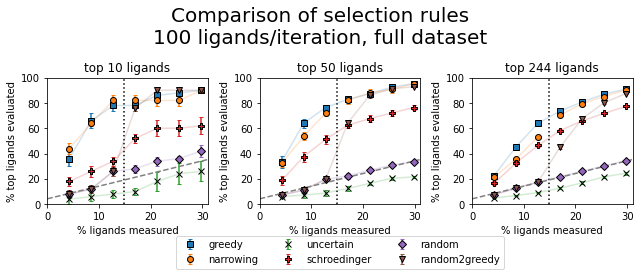

In [108]:
pgroups=["top10_found", "top50_found", "top244_found"]
labels=["top 10", "top 50", "top 244"]
sizes=[10,50,244]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

# x=np.arange(len(run_mean_hist_by_sele_method[0].RMSD_XVal))
# x=100*7*(x+1)/2351 # convert to percent

n_sub_plots=len(pgroups)
fig, axs = plt.subplots(1, n_sub_plots, figsize=[n_sub_plots*3, 1*3+0.5], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
    plt.xlabel("% ligands measured")
    plt.ylabel("% top ligands evaluated")
    plt.title(labels[sp]+" ligands")
    
    for cnum in range(len(sele_method_names)):
        lbl=sele_method_names[cnum]
        atrname=pgroups[sp]
        y_avg=getattr(run_mean_hist_by_sele_method[cnum], atrname)
        y_sem=getattr(run_mean_hist_by_sele_method[cnum], atrname+"_err")
        
        x=getattr(run_mean_hist_by_sele_method[cnum], "num_known_ligs_at_step")*100/2351
        
        ls="solid"
        lw=1.5
        
        if(lbl=="narrowing"):
            plt.plot(x[:3], 100.*y_avg[:3]/sizes[sp], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.plot(x[3:], 100.*y_avg[3:]/sizes[sp], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.errorbar(x, 100.*y_avg/sizes[sp], yerr=100.*y_sem/sizes[sp], c=f"C{cnum}",
                         marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
        else:
            plt.plot(x, 100.*y_avg/sizes[sp], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.errorbar(x, 100.*y_avg/sizes[sp], yerr=100.*y_sem/sizes[sp], c=f"C{cnum}",
                         marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()
    
    diag=np.arange(0,100, 2)
    plt.plot(diag, diag+100*100/2351, ls='dashed', color='grey')

    #plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
    #plt.gca().set_ylim((0,250))

    #plt.vlines(100*7*(2.5+1)/2351, 0, 100, colors="black", linestyles='dotted')
    plt.vlines(100*3.5*100/2351, 0, 100, colors="black", linestyles='dotted')
    plt.gca().set_ylim((0,100))
    plt.gca().set_xlim((0,xlim[1]))

    plt.suptitle("Comparison of selection rules\n100 ligands/iteration, full dataset", size=20)
    plt.tight_layout(rect=[0, 0.03, 1, 1.01])

#axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=4)
axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.55), ncol=3)
plt.show()

## top_identified figure (by models at each iter)

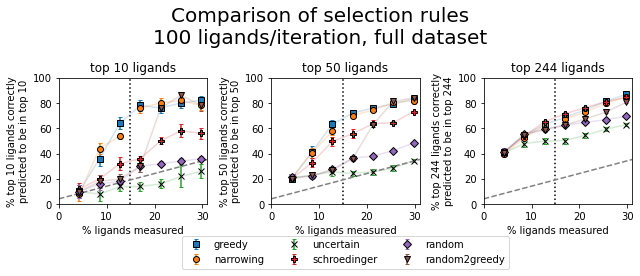

In [109]:
pgroups=["top10_correctly_predicted", "top50_correctly_predicted", "top244_correctly_predicted"]
labels=["top 10", "top 50", "top 244"]
sizes=[10,50,244]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

# x=np.arange(len(run_mean_hist_by_sele_method[0].RMSD_XVal))
# x=100*7*(x+1)/2351 # convert to percent

n_sub_plots=len(pgroups)
fig, axs = plt.subplots(1, n_sub_plots, figsize=[n_sub_plots*3, 1*3+0.5], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
    plt.xlabel("% ligands measured")
    plt.ylabel(f"% top {sizes[sp]} ligands correctly\npredicted to be in top {sizes[sp]}")
    plt.title(labels[sp]+" ligands")
    
    for cnum in range(len(sele_method_names)):
        lbl=sele_method_names[cnum]
        atrname=pgroups[sp]
        y_avg=getattr(run_mean_hist_by_sele_method[cnum], atrname)
        y_sem=getattr(run_mean_hist_by_sele_method[cnum], atrname+"_err")
        
        x=getattr(run_mean_hist_by_sele_method[cnum], "num_known_ligs_at_step")*100/2351
        
        ls="solid"
        lw=1.5
        
        if(lbl=="narrowing"):
            plt.plot(x[:3], 100.*y_avg[:3]/sizes[sp], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.plot(x[3:], 100.*y_avg[3:]/sizes[sp], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.errorbar(x, 100.*y_avg/sizes[sp], yerr=100.*y_sem/sizes[sp], c=f"C{cnum}",
                         marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
        else:
            plt.plot(x, 100.*y_avg/sizes[sp], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.errorbar(x, 100.*y_avg/sizes[sp], yerr=100.*y_sem/sizes[sp], c=f"C{cnum}",
                         marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()
    
    diag=np.arange(0,100, 2)
    plt.plot(diag, diag+100*100/2351, ls='dashed', color='grey')

    #plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
    #plt.gca().set_ylim((0,250))

    #plt.vlines(100*7*(2.5+1)/2351, 0, 100, colors="black", linestyles='dotted')
    plt.vlines(100*3.5*100/2351, 0, 100, colors="black", linestyles='dotted')
    plt.gca().set_ylim((0,100))
    plt.gca().set_xlim((0,xlim[1]))

    plt.suptitle("Comparison of selection rules\n100 ligands/iteration, full dataset", size=20)
    plt.tight_layout(rect=[0, 0.03, 1, 1.01])

#axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=4)
axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.55), ncol=3)
plt.show()

## dump metrics to pickle

In [16]:
pickle.dump( run_mean_hist_by_sele_method, open( "convergence_full_dataset_4.25_percent_per_iter.pickle", "wb" ) )

# minimalistic figure

In [ ]:
pgroups=["XVal", "selected", "unmeasured", "top10"]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

#x=np.arange(len(run_mean_hist.RMSD_XVal))

wanted_metrics=[0,1,4]
ylimits=[(0,5), (-0.5,1), (0,1)]
method_names=[
    "greedy",
    "narrowing",
    "uncertain",
    "schroedinger"
]

n_sub_plots=len(wanted_metrics)
fig, axs = plt.subplots(len(pgroups), n_sub_plots, figsize=[n_sub_plots*3, len(pgroups)*2.5+0.5], facecolor='w')
for row in range(len(pgroups)):
    for sp in range(n_sub_plots):
        plt.sca(axs[row,sp])
        plt.xlabel("% ligands measured")
        plt.ylabel(run_mean_hist_by_sele_method[0].metrics[wanted_metrics[sp]])

        for cnum in range(len(method_names)):
            lw=1.5
            lbl=method_names[cnum]
            ls="solid"
            if("top" in lbl):
                ls="dashed"
            atrname=run_mean_hist_by_sele_method[0].metrics[wanted_metrics[sp]]+'_'+pgroups[row]
            
            x=getattr(run_mean_hist_by_sele_method[cnum], "num_known_ligs_at_step")*100/2351

            if not hasattr(run_mean_hist_by_sele_method[cnum], atrname+"_err"):
                continue;
            y_avg=getattr(run_mean_hist_by_sele_method[cnum], atrname)
            y_sem=getattr(run_mean_hist_by_sele_method[cnum], atrname+"_err")
            if(len(y_avg)!=len(x)):
                continue;
                
            if(cnum!=1):
                plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
                plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}", marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

            if(cnum==1):
                #plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
                plt.vlines(100*100*3.5/2351, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')

                plt.plot(x[:3], y_avg[:3], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
                plt.plot(x[3:], y_avg[3:], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
                plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}", marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

        
        plt.ylim(ylimits[sp])
        
        
    pad=3
    axs[row,0].annotate(pgroups[row],
                xy=(0, 0.5), xytext=(-axs[row,0].yaxis.labelpad - pad, 0),
                xycoords=axs[row,0].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
        
plt.suptitle("Active learing on experimental dataset\n100 ligands/iteration", size=20)
plt.tight_layout(rect=[0, 0.03, 1, 1.01])

plt.sca(axs[len(pgroups)-1,0])
plt.legend(loc='lower center', bbox_to_anchor=(2, -0.45), ncol=len(method_names))
plt.show()

# For Hunfeld poster

In [ ]:
pgroups=["top10_found", "top50_found", "top244_found"]
labels=["top 10", "top 50", "top 244"]
sizes=[10,50,244]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

# x=np.arange(len(run_mean_hist_by_sele_method[0].RMSD_XVal))
# x=100*7*(x+1)/2351 # convert to percent

n_sub_plots=len(pgroups)
fig, axs = plt.subplots(1, n_sub_plots, figsize=[1.2*n_sub_plots*3, 1.2*4], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
    plt.xlabel("Step", size=16)
    plt.ylabel("% top ligands found", size=16)
    plt.title(labels[sp]+" ligands", size=18)
    
    plt.tick_params(axis='x', labelsize=14 )
    plt.tick_params(axis='y', labelsize=14 )
    
    if(sp!=0):
        axs[sp].axes.yaxis.set_ticklabels([])
        axs[sp].set_ylabel("")

    
    for cnum in range(len(sele_method_names)):
        lbl=sele_method_names[cnum]
        atrname=pgroups[sp]
        y_avg=getattr(run_mean_hist_by_sele_method[cnum], atrname)
        y_sem=getattr(run_mean_hist_by_sele_method[cnum], atrname+"_err")
        
        #x=getattr(run_mean_hist_by_sele_method[cnum], "num_known_ligs_at_step")*100/2351
        x=np.arange(7)+1
        
        ls="solid"
        lw=2
        
        if(lbl=="narrowing"):
            lbl="our"
            plt.plot(x[:3], 100.*y_avg[:3]/sizes[sp], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.plot(x[3:], 100.*y_avg[3:]/sizes[sp], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.errorbar(x, 100.*y_avg/sizes[sp], yerr=100.*y_sem/sizes[sp], c=f"C{cnum}",
                         marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
        else:
            plt.plot(x, 100.*y_avg/sizes[sp], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.errorbar(x, 100.*y_avg/sizes[sp], yerr=100.*y_sem/sizes[sp], c=f"C{cnum}",
                         marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()
    
    #diag=np.arange(0,100, 2)
    #plt.plot(diag, diag+100*100/2351, ls='dashed', color='grey')

    #plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
    #plt.gca().set_ylim((0,250))

    #plt.vlines(100*7*(2.5+1)/2351, 0, 100, colors="black", linestyles='dotted')
    #plt.vlines(100*3.5*100/2351, 0, 100, colors="black", linestyles='dotted')
    plt.vlines(2.5, 0, 100, colors="black", linestyles='dotted')
    plt.gca().set_ylim((0,100))
    #plt.gca().set_xlim((min(0,xlim[0]),xlim[1]))
    plt.gca().set_xlim((xlim[0],xlim[1]))
    
    plt.suptitle("2351 ligand experimental library; 100 ligands/step", size=20)
    plt.tight_layout(rect=[0, 0.07, 1, 1.01])

#axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=4)
axs[2].legend(loc='lower center', bbox_to_anchor=(-0.5, -0.35), ncol=5, prop={'size': 12})

Hunfeld_outfolder="/home/ykhalak/Documents/Presentations/Hunfeld_2022_poster/"
plt.savefig(f"{Hunfeld_outfolder}/retrospective_v0.png",
                dpi='figure',
                facecolor='w'
               )
plt.show()

In [ ]:
print(run_mean_hist_by_sele_method[0].top50_found)
print(run_mean_hist_by_sele_method[0].top50_found_err)

print(run_mean_hist_by_sele_method[0].KT_top50)
print(run_mean_hist_by_sele_method[0].KT_top50_err)

In [ ]:
import matplotlib.ticker as ticker

pgroups=["RMSD_top50", "KT_top50", "top50_found"]
labels=["RMSD (kcal/mol)", "Kendel-Tau correlation", "% of top 50 ligands found"]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

# x=np.arange(len(run_mean_hist_by_sele_method[0].RMSD_XVal))
# x=100*7*(x+1)/2351 # convert to percent

n_sub_plots=len(pgroups)
#fig, axs = plt.subplots(1, n_sub_plots, figsize=[1.2*n_sub_plots*3, 1.2*4], facecolor='w')
fig, axs = plt.subplots(1, n_sub_plots, figsize=[1.2*n_sub_plots*3, 1.2*3.6], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
    plt.xlabel("Iteration", size=16)
    plt.ylabel(labels[sp], size=16)
    axs[sp].xaxis.set_major_locator(ticker.MultipleLocator(1))
    #plt.title(labels[sp]+" ligands", size=18)
    
    plt.tick_params(axis='x', labelsize=14 )
    plt.tick_params(axis='y', labelsize=14 )
    
#     if(sp!=0):
#         axs[sp].axes.yaxis.set_ticklabels([])
#         axs[sp].set_ylabel("")

    
    for cnum in range(len(sele_method_names)):
        lbl=sele_method_names[cnum]
        if(lbl=="random" and sp!=2):
            continue;
        atrname=pgroups[sp]
        y_avg=getattr(run_mean_hist_by_sele_method[cnum], atrname)
        y_sem=getattr(run_mean_hist_by_sele_method[cnum], atrname+"_err")
        
        if(atrname=="top50_found"):
            y_avg=y_avg*100/50
            y_sem=y_sem*100/50
        
        #x=getattr(run_mean_hist_by_sele_method[cnum], "num_known_ligs_at_step")*100/2351
        x=np.arange(7)+1
        
        ls="solid"
        lw=2
        if(lbl=="schroedinger"):
            lbl="mixed"
        
        if(lbl=="narrowing"):
            #lbl="our"
            lbl="narrowing"
            plt.plot(x[:3], y_avg[:3], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.plot(x[3:], y_avg[3:], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                         marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
        else:
            plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                         marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()
    
    #diag=np.arange(0,100, 2)
    #plt.plot(diag, diag+100*100/2351, ls='dashed', color='grey')

    #plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
    #plt.gca().set_ylim((0,250))

    #plt.vlines(100*7*(2.5+1)/2351, 0, 100, colors="black", linestyles='dotted')
    #plt.vlines(100*3.5*100/2351, 0, 100, colors="black", linestyles='dotted')
    
    ylim=plt.gca().get_ylim()
    plt.vlines(2.5, ylim[0], ylim[1], colors="black", linestyles='dotted')
    #plt.gca().set_ylim((0,100))
    plt.gca().set_xlim((xlim[0],xlim[1]))
    
    plt.suptitle("Convergence metrics for top 50 strongest binding ligands", size=20)
    plt.tight_layout(rect=[0, 0.07, 1, 1.01])

#axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=4)
axs[2].legend(loc='lower center', bbox_to_anchor=(-1, -0.35), ncol=5, prop={'size': 12})

Hunfeld_outfolder="/home/ykhalak/Documents/Presentations/Hunfeld_2022_poster/"
plt.savefig(f"{Hunfeld_outfolder}/retrospective_v1.png",
                dpi='figure',
                facecolor='w'
               )
plt.show()

In [ ]:
# import matplotlib.ticker as ticker

pgroups=["top50_found"]
labels=["% of top 50\nligands found"]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

# x=np.arange(len(run_mean_hist_by_sele_method[0].RMSD_XVal))
# x=100*7*(x+1)/2351 # convert to percent

n_sub_plots=len(pgroups)
#fig, axs = plt.subplots(1, n_sub_plots, figsize=[1.2*n_sub_plots*3, 1.2*4], facecolor='w')
fig, axs = plt.subplots(1, n_sub_plots, figsize=[1.2*n_sub_plots*3.6, 1*3], facecolor='w')
axs=[axs]
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
    plt.xlabel("Iteration", size=16)
    plt.ylabel(labels[sp], size=16)
    axs[sp].xaxis.set_major_locator(ticker.MultipleLocator(1))
    #plt.title(labels[sp]+" ligands", size=18)
    
    plt.tick_params(axis='x', labelsize=14 )
    plt.tick_params(axis='y', labelsize=14 )
    
#     if(sp!=0):
#         axs[sp].axes.yaxis.set_ticklabels([])
#         axs[sp].set_ylabel("")

    
    for cnum in range(len(sele_method_names)):
        lbl=sele_method_names[cnum]
#         if(lbl=="random" and sp!=2):
#             continue;
        atrname=pgroups[sp]
        y_avg=getattr(run_mean_hist_by_sele_method[cnum], atrname)
        y_sem=getattr(run_mean_hist_by_sele_method[cnum], atrname+"_err")
        
        if(atrname=="top50_found"):
            y_avg=y_avg*100/50
            y_sem=y_sem*100/50
        
        #x=getattr(run_mean_hist_by_sele_method[cnum], "num_known_ligs_at_step")*100/2351
        x=np.arange(7)+1
        
        ls="solid"
        lw=2
        if(lbl=="schroedinger"):
            lbl="mixed"
        
        if(lbl=="narrowing"):
            #lbl="our"
            lbl="narrowing"
            plt.plot(x[:3], y_avg[:3], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.plot(x[3:], y_avg[3:], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                         marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
        else:
            plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                         marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()
    
    #diag=np.arange(0,100, 2)
    #plt.plot(diag, diag+100*100/2351, ls='dashed', color='grey')

    #plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
    #plt.gca().set_ylim((0,250))

    #plt.vlines(100*7*(2.5+1)/2351, 0, 100, colors="black", linestyles='dotted')
    #plt.vlines(100*3.5*100/2351, 0, 100, colors="black", linestyles='dotted')
    
    ylim=plt.gca().get_ylim()
    plt.vlines(2.5, ylim[0], ylim[1], colors="black", linestyles='dotted')
    #plt.gca().set_ylim((0,100))
    plt.gca().set_xlim((xlim[0],xlim[1]))
    
#     plt.suptitle("Convergence metrics for top 50 strongest binding ligands", size=20)
    plt.tight_layout(rect=[0.1, 0.0, 1, 1])

axs[0].legend(loc='upper right', bbox_to_anchor=(1.6, 1), ncol=1, prop={'size': 12})
    
outfolder="/home/ykhalak/Documents/Presentations/DeptSeminar_April2022/"
plt.savefig(f"{outfolder}/sele_top_50.png",
                bbox_inches="tight",
                dpi=300,
                facecolor='w'
               )
plt.show()

# Version for paper

### version for paper v1

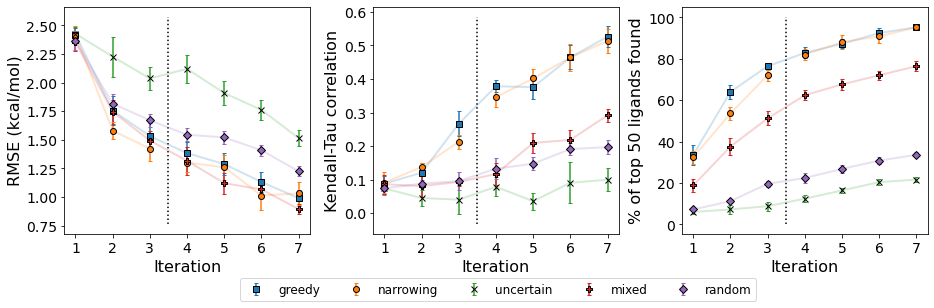

In [28]:
import matplotlib.ticker as ticker

pgroups=["RMSD_top50", "KT_top50", "top50_found"]
labels=["RMSE (kcal/mol)", "Kendall-Tau correlation", "% of top 50 ligands found"]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

# x=np.arange(len(run_mean_hist_by_sele_method[0].RMSD_XVal))
# x=100*7*(x+1)/2351 # convert to percent

n_sub_plots=len(pgroups)
#fig, axs = plt.subplots(1, n_sub_plots, figsize=[1.2*n_sub_plots*3, 1.2*4], facecolor='w')
fig, axs = plt.subplots(1, n_sub_plots, figsize=[1.2*n_sub_plots*3.6, 1.2*3.6], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
    plt.xlabel("Iteration", size=16)
    plt.ylabel(labels[sp], size=16)
    axs[sp].xaxis.set_major_locator(ticker.MultipleLocator(1))
    #plt.title(labels[sp]+" ligands", size=18)
    
    plt.tick_params(axis='x', labelsize=14 )
    plt.tick_params(axis='y', labelsize=14 )
    
#     if(sp!=0):
#         axs[sp].axes.yaxis.set_ticklabels([])
#         axs[sp].set_ylabel("")

    
    for cnum in range(len(sele_method_names)):
        lbl=sele_method_names[cnum]
#         if(lbl=="random" and sp!=2):
#             continue;
        atrname=pgroups[sp]
        y_avg=getattr(run_mean_hist_by_sele_method[cnum], atrname)
        y_sem=getattr(run_mean_hist_by_sele_method[cnum], atrname+"_err")
        
        if(atrname=="top50_found"):
            y_avg=y_avg*100/50
            y_sem=y_sem*100/50
        
        #x=getattr(run_mean_hist_by_sele_method[cnum], "num_known_ligs_at_step")*100/2351
        x=np.arange(7)+1
        
        ls="solid"
        lw=2
        if(lbl=="schroedinger"):
            #lbl="Schrödinger"
            lbl="mixed"
        
        if(lbl=="narrowing"):
            lbl="narrowing"
            plt.plot(x[:3], y_avg[:3], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.plot(x[3:], y_avg[3:], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                         marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
        else:
            plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                         marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()
    
    #diag=np.arange(0,100, 2)
    #plt.plot(diag, diag+100*100/2351, ls='dashed', color='grey')

    #plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
    #plt.gca().set_ylim((0,250))

    #plt.vlines(100*7*(2.5+1)/2351, 0, 100, colors="black", linestyles='dotted')
    #plt.vlines(100*3.5*100/2351, 0, 100, colors="black", linestyles='dotted')
    
    ylim=plt.gca().get_ylim()
    plt.vlines(3.5, ylim[0], ylim[1], colors="black", linestyles='dotted')
    #plt.gca().set_ylim((0,100))
    plt.gca().set_xlim((xlim[0],xlim[1]))
    
    #plt.suptitle("Convergence metrics for top 50 strongest binding ligands", size=20)
    plt.tight_layout(rect=[0, 0.07, 1, 1])

#axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=4)
axs[2].legend(loc='lower center', bbox_to_anchor=(-0.75, -0.32), ncol=5, prop={'size': 12})

plt.savefig(f"sele_method_convergence.png",
                dpi='figure',
                facecolor='w'
               )
plt.show()

### version for paper V2

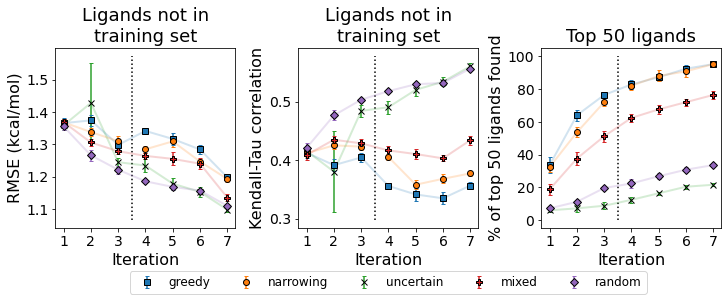

In [26]:
import matplotlib.ticker as ticker

pgroups=["RMSD_unmeasured", "KT_unmeasured", "top50_found"]
labels=["RMSE (kcal/mol)", "Kendall-Tau correlation", "% of top 50 ligands found"]
titles=["Ligands not in\ntraining set", "Ligands not in\ntraining set", "Top 50 ligands"]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

# x=np.arange(len(run_mean_hist_by_sele_method[0].RMSD_XVal))
# x=100*7*(x+1)/2351 # convert to percent

n_sub_plots=len(pgroups)
n_sp_x=width=n_sub_plots
n_sp_y=height=1
subp_size=2.5

hspace=0.05#*(height)
wspace=0.35#*(width)

t_pad_factor_h=0.25 #of subp_size
b_pad_factor_h=0.40#0.2 #of subp_size
r_pad_factor_w=0.12#0.05 #of subp_size
l_pad_factor_w=0.30#0.32 #of subp_size
pad_factor_to_cbar=0 #of subp_size
pad_factor_w=(r_pad_factor_w+l_pad_factor_w)*0.5+pad_factor_to_cbar
pad_factor_h=(t_pad_factor_h+b_pad_factor_h)*0.5
fig_h=(height+2*pad_factor_h+(height-1)*hspace)*subp_size
fig_w=(width+2*pad_factor_w+(width-1)*wspace)*subp_size #- 0.6*subp_size

top_pad=t_pad_factor_h*subp_size/fig_h
bot_pad=b_pad_factor_h*subp_size/fig_h
right_pad=r_pad_factor_w*subp_size/fig_w
left_pad=l_pad_factor_w*subp_size/fig_w


fig, axs = plt.subplots(height, width, figsize=[fig_w, fig_h], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
    plt.xlabel("Iteration", size=16)
    plt.ylabel(labels[sp], size=16)
    axs[sp].xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.title(titles[sp], size=18)
    
    plt.tick_params(axis='x', labelsize=14 )
    plt.tick_params(axis='y', labelsize=14 )
    
#     if(sp!=0):
#         axs[sp].axes.yaxis.set_ticklabels([])
#         axs[sp].set_ylabel("")

    
    for cnum in range(len(sele_method_names)):
        lbl=sele_method_names[cnum]
#         if(lbl=="random" and sp!=2):
#             continue;
        atrname=pgroups[sp]
        y_avg=getattr(run_mean_hist_by_sele_method[cnum], atrname)
        y_sem=getattr(run_mean_hist_by_sele_method[cnum], atrname+"_err")
        
        if(atrname=="top50_found"):
            y_avg=y_avg*100/50
            y_sem=y_sem*100/50
        
        #x=getattr(run_mean_hist_by_sele_method[cnum], "num_known_ligs_at_step")*100/2351
        x=np.arange(7)+1
        
        ls="solid"
        lw=2
        if(lbl=="schroedinger"):
            #lbl="Schrödinger"
            lbl="mixed"
        
        if(lbl=="narrowing"):
            lbl="narrowing"
            plt.plot(x[:3], y_avg[:3], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.plot(x[3:], y_avg[3:], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                         marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
        else:
            plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                         marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()
    
    #diag=np.arange(0,100, 2)
    #plt.plot(diag, diag+100*100/2351, ls='dashed', color='grey')

    #plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
    #plt.gca().set_ylim((0,250))

    #plt.vlines(100*7*(2.5+1)/2351, 0, 100, colors="black", linestyles='dotted')
    #plt.vlines(100*3.5*100/2351, 0, 100, colors="black", linestyles='dotted')
    
    ylim=plt.gca().get_ylim()
    plt.vlines(3.5, ylim[0], ylim[1], colors="black", linestyles='dotted')
    #plt.gca().set_ylim((0,100))
    plt.gca().set_xlim((xlim[0],xlim[1]))
    
    #plt.suptitle("Convergence metrics for top 50 strongest binding ligands", size=20)
    #plt.tight_layout(rect=[0, 0.07, 1, 1])

plt.subplots_adjust(top=1-top_pad, right=1-right_pad, wspace=wspace, hspace=hspace, left=left_pad, bottom=bot_pad)
    
#axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=4)
#axs[2].legend(loc='lower center', bbox_to_anchor=(-0.75, -0.32), ncol=5, prop={'size': 12})
if(n_sub_plots%2==0):
    legend_shift=0    
else:
    legend_shift=0.5
axs[int(n_sub_plots/2)].legend(loc='lower center', bbox_to_anchor=(legend_shift, -0.40), ncol=6, prop={'size': 12})

plt.savefig(f"sele_method_convergence_v2.png",
                dpi='figure',
                facecolor='w'
               )
plt.show()

### version for paper v3

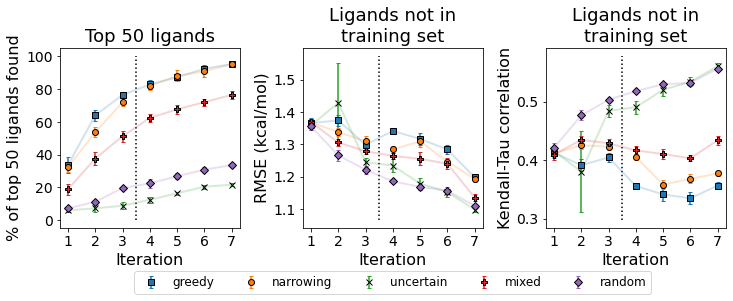

In [24]:
import matplotlib.ticker as ticker

#pgroups=["RMSD_unmeasured", "KT_unmeasured", "top50_found"]
#labels=["RMSE (kcal/mol)", "Kendall-Tau correlation", "% of top 50 ligands found"]
#titles=["Ligands not in\ntraining set", "Ligands not in\ntraining set", "Top 50 ligands"]
pgroups=["top50_found", "RMSD_unmeasured", "KT_unmeasured"]
labels=["% of top 50 ligands found", "RMSE (kcal/mol)", "Kendall-Tau correlation"]
titles=["Top 50 ligands", "Ligands not in\ntraining set", "Ligands not in\ntraining set"]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

# x=np.arange(len(run_mean_hist_by_sele_method[0].RMSD_XVal))
# x=100*7*(x+1)/2351 # convert to percent

n_sub_plots=len(pgroups)
n_sp_x=width=n_sub_plots
n_sp_y=height=1
subp_size=2.5

hspace=0.05#*(height)
wspace=0.35#*(width)

t_pad_factor_h=0.25 #of subp_size
b_pad_factor_h=0.40#0.2 #of subp_size
r_pad_factor_w=0.12#0.05 #of subp_size
l_pad_factor_w=0.30#0.32 #of subp_size
pad_factor_to_cbar=0 #of subp_size
pad_factor_w=(r_pad_factor_w+l_pad_factor_w)*0.5+pad_factor_to_cbar
pad_factor_h=(t_pad_factor_h+b_pad_factor_h)*0.5
fig_h=(height+2*pad_factor_h+(height-1)*hspace)*subp_size
fig_w=(width+2*pad_factor_w+(width-1)*wspace)*subp_size #- 0.6*subp_size

top_pad=t_pad_factor_h*subp_size/fig_h
bot_pad=b_pad_factor_h*subp_size/fig_h
right_pad=r_pad_factor_w*subp_size/fig_w
left_pad=l_pad_factor_w*subp_size/fig_w


fig, axs = plt.subplots(height, width, figsize=[fig_w, fig_h], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
    plt.xlabel("Iteration", size=16)
    plt.ylabel(labels[sp], size=16)
    axs[sp].xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.title(titles[sp], size=18)
    
    plt.tick_params(axis='x', labelsize=14 )
    plt.tick_params(axis='y', labelsize=14 )
    
#     if(sp!=0):
#         axs[sp].axes.yaxis.set_ticklabels([])
#         axs[sp].set_ylabel("")

    
    for cnum in range(len(sele_method_names)):
        lbl=sele_method_names[cnum]
#         if(lbl=="random" and sp!=2):
#             continue;
        atrname=pgroups[sp]
        y_avg=getattr(run_mean_hist_by_sele_method[cnum], atrname)
        y_sem=getattr(run_mean_hist_by_sele_method[cnum], atrname+"_err")
        
        if(atrname=="top50_found"):
            y_avg=y_avg*100/50
            y_sem=y_sem*100/50
        
        #x=getattr(run_mean_hist_by_sele_method[cnum], "num_known_ligs_at_step")*100/2351
        x=np.arange(7)+1
        
        ls="solid"
        lw=2
        if(lbl=="schroedinger"):
            #lbl="Schrödinger"
            lbl="mixed"
        
        if(lbl=="narrowing"):
            lbl="narrowing"
            plt.plot(x[:3], y_avg[:3], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.plot(x[3:], y_avg[3:], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                         marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
        else:
            plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                         marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()
    
    #diag=np.arange(0,100, 2)
    #plt.plot(diag, diag+100*100/2351, ls='dashed', color='grey')

    #plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
    #plt.gca().set_ylim((0,250))

    #plt.vlines(100*7*(2.5+1)/2351, 0, 100, colors="black", linestyles='dotted')
    #plt.vlines(100*3.5*100/2351, 0, 100, colors="black", linestyles='dotted')
    
    ylim=plt.gca().get_ylim()
    plt.vlines(3.5, ylim[0], ylim[1], colors="black", linestyles='dotted')
    #plt.gca().set_ylim((0,100))
    plt.gca().set_xlim((xlim[0],xlim[1]))
    
    #plt.suptitle("Convergence metrics for top 50 strongest binding ligands", size=20)
    #plt.tight_layout(rect=[0, 0.07, 1, 1])

plt.subplots_adjust(top=1-top_pad, right=1-right_pad, wspace=wspace, hspace=hspace, left=left_pad, bottom=bot_pad)
    
#axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=4)
#axs[2].legend(loc='lower center', bbox_to_anchor=(-0.75, -0.32), ncol=5, prop={'size': 12})
if(n_sub_plots%2==0):
    legend_shift=0    
else:
    legend_shift=0.5
axs[int(n_sub_plots/2)].legend(loc='lower center', bbox_to_anchor=(legend_shift, -0.40), ncol=6, prop={'size': 12})

plt.savefig(f"sele_method_convergence_v3.png",
                dpi='figure',
                facecolor='w'
               )
plt.show()

### version for paper v4 (top 50 correctly predicted)

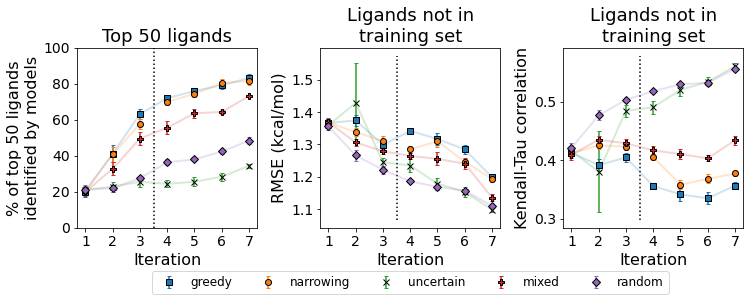

In [112]:
import matplotlib.ticker as ticker

#sele_method_names=["greedy", "narrowing", "uncertain", "schroedinger", "random", "random2greedy"]
sele_method_names=["greedy", "narrowing", "uncertain", "schroedinger", "random"]

#pgroups=["RMSD_unmeasured", "KT_unmeasured", "top50_found"]
#labels=["RMSE (kcal/mol)", "Kendall-Tau correlation", "% of top 50 ligands found"]
#titles=["Ligands not in\ntraining set", "Ligands not in\ntraining set", "Top 50 ligands"]
pgroups=["top50_correctly_predicted", "RMSD_unmeasured", "KT_unmeasured"]
labels=["% of top 50 ligands\nidentified by models", "RMSE (kcal/mol)", "Kendall-Tau correlation"]
titles=["Top 50 ligands", "Ligands not in\ntraining set", "Ligands not in\ntraining set"]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

# x=np.arange(len(run_mean_hist_by_sele_method[0].RMSD_XVal))
# x=100*7*(x+1)/2351 # convert to percent

n_sub_plots=len(pgroups)
n_sp_x=width=n_sub_plots
n_sp_y=height=1
subp_size=2.5

hspace=0.05#*(height)
wspace=0.35#*(width)

t_pad_factor_h=0.25 #of subp_size
b_pad_factor_h=0.40#0.2 #of subp_size
r_pad_factor_w=0.12#0.05 #of subp_size
l_pad_factor_w=0.40#0.32 #of subp_size
pad_factor_to_cbar=0 #of subp_size
pad_factor_w=(r_pad_factor_w+l_pad_factor_w)*0.5+pad_factor_to_cbar
pad_factor_h=(t_pad_factor_h+b_pad_factor_h)*0.5
fig_h=(height+2*pad_factor_h+(height-1)*hspace)*subp_size
fig_w=(width+2*pad_factor_w+(width-1)*wspace)*subp_size #- 0.6*subp_size

top_pad=t_pad_factor_h*subp_size/fig_h
bot_pad=b_pad_factor_h*subp_size/fig_h
right_pad=r_pad_factor_w*subp_size/fig_w
left_pad=l_pad_factor_w*subp_size/fig_w


fig, axs = plt.subplots(height, width, figsize=[fig_w, fig_h], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
    plt.xlabel("Iteration", size=16)
    plt.ylabel(labels[sp], size=16)
    axs[sp].xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.title(titles[sp], size=18)
    
    plt.tick_params(axis='x', labelsize=14 )
    plt.tick_params(axis='y', labelsize=14 )
    
#     if(sp!=0):
#         axs[sp].axes.yaxis.set_ticklabels([])
#         axs[sp].set_ylabel("")

    
    for cnum in range(len(sele_method_names)):
        lbl=sele_method_names[cnum]
#         if(lbl=="random" and sp!=2):
#             continue;
        atrname=pgroups[sp]
        y_avg=getattr(run_mean_hist_by_sele_method[cnum], atrname)
        y_sem=getattr(run_mean_hist_by_sele_method[cnum], atrname+"_err")
        
        if(atrname=="top50_found" or atrname=="top50_correctly_predicted"):
            y_avg=y_avg*100/50
            y_sem=y_sem*100/50
            plt.gca().set_ylim(0,100)
        
        #x=getattr(run_mean_hist_by_sele_method[cnum], "num_known_ligs_at_step")*100/2351
        x=np.arange(7)+1
        
        ls="solid"
        lw=2
        if(lbl=="schroedinger"):
            #lbl="Schrödinger"
            lbl="mixed"
        
        if(lbl=="narrowing" or lbl=="random2greedy"):
#             lbl="narrowing"
            plt.plot(x[:3], y_avg[:3], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.plot(x[3:], y_avg[3:], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                         marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
        else:
            plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                         marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()
    
    #diag=np.arange(0,100, 2)
    #plt.plot(diag, diag+100*100/2351, ls='dashed', color='grey')

    #plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
    #plt.gca().set_ylim((0,250))

    #plt.vlines(100*7*(2.5+1)/2351, 0, 100, colors="black", linestyles='dotted')
    #plt.vlines(100*3.5*100/2351, 0, 100, colors="black", linestyles='dotted')
    
    ylim=plt.gca().get_ylim()
    plt.vlines(3.5, ylim[0], ylim[1], colors="black", linestyles='dotted')
    #plt.gca().set_ylim((0,100))
    plt.gca().set_xlim((xlim[0],xlim[1]))
    
    #plt.suptitle("Convergence metrics for top 50 strongest binding ligands", size=20)
    #plt.tight_layout(rect=[0, 0.07, 1, 1])

plt.subplots_adjust(top=1-top_pad, right=1-right_pad, wspace=wspace, hspace=hspace, left=left_pad, bottom=bot_pad)
    
#axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=4)
#axs[2].legend(loc='lower center', bbox_to_anchor=(-0.75, -0.32), ncol=5, prop={'size': 12})
if(n_sub_plots%2==0):
    legend_shift=0    
else:
    legend_shift=0.5
axs[int(n_sub_plots/2)].legend(loc='lower center', bbox_to_anchor=(legend_shift, -0.40), ncol=6, prop={'size': 12})

plt.savefig(f"sele_method_convergence_v4.png",
                dpi=300,
                facecolor='w'
               )
plt.show()

### version 5 for SI (w random2greedy)

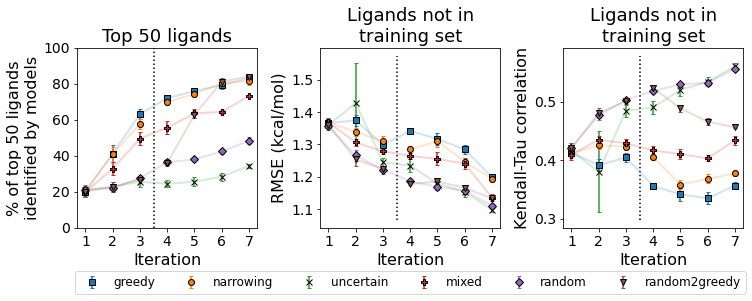

In [113]:
import matplotlib.ticker as ticker

sele_method_names=["greedy", "narrowing", "uncertain", "schroedinger", "random", "random2greedy"]
#sele_method_names=["greedy", "narrowing", "uncertain", "schroedinger", "random"]

#pgroups=["RMSD_unmeasured", "KT_unmeasured", "top50_found"]
#labels=["RMSE (kcal/mol)", "Kendall-Tau correlation", "% of top 50 ligands found"]
#titles=["Ligands not in\ntraining set", "Ligands not in\ntraining set", "Top 50 ligands"]
pgroups=["top50_correctly_predicted", "RMSD_unmeasured", "KT_unmeasured"]
labels=["% of top 50 ligands\nidentified by models", "RMSE (kcal/mol)", "Kendall-Tau correlation"]
titles=["Top 50 ligands", "Ligands not in\ntraining set", "Ligands not in\ntraining set"]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

# x=np.arange(len(run_mean_hist_by_sele_method[0].RMSD_XVal))
# x=100*7*(x+1)/2351 # convert to percent

n_sub_plots=len(pgroups)
n_sp_x=width=n_sub_plots
n_sp_y=height=1
subp_size=2.5

hspace=0.05#*(height)
wspace=0.35#*(width)

t_pad_factor_h=0.25 #of subp_size
b_pad_factor_h=0.40#0.2 #of subp_size
r_pad_factor_w=0.12#0.05 #of subp_size
l_pad_factor_w=0.40#0.32 #of subp_size
pad_factor_to_cbar=0 #of subp_size
pad_factor_w=(r_pad_factor_w+l_pad_factor_w)*0.5+pad_factor_to_cbar
pad_factor_h=(t_pad_factor_h+b_pad_factor_h)*0.5
fig_h=(height+2*pad_factor_h+(height-1)*hspace)*subp_size
fig_w=(width+2*pad_factor_w+(width-1)*wspace)*subp_size #- 0.6*subp_size

top_pad=t_pad_factor_h*subp_size/fig_h
bot_pad=b_pad_factor_h*subp_size/fig_h
right_pad=r_pad_factor_w*subp_size/fig_w
left_pad=l_pad_factor_w*subp_size/fig_w


fig, axs = plt.subplots(height, width, figsize=[fig_w, fig_h], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
    plt.xlabel("Iteration", size=16)
    plt.ylabel(labels[sp], size=16)
    axs[sp].xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.title(titles[sp], size=18)
    
    plt.tick_params(axis='x', labelsize=14 )
    plt.tick_params(axis='y', labelsize=14 )
    
#     if(sp!=0):
#         axs[sp].axes.yaxis.set_ticklabels([])
#         axs[sp].set_ylabel("")

    
    for cnum in range(len(sele_method_names)):
        lbl=sele_method_names[cnum]
#         if(lbl=="random" and sp!=2):
#             continue;
        atrname=pgroups[sp]
        y_avg=getattr(run_mean_hist_by_sele_method[cnum], atrname)
        y_sem=getattr(run_mean_hist_by_sele_method[cnum], atrname+"_err")
        
        if(atrname=="top50_found" or atrname=="top50_correctly_predicted"):
            y_avg=y_avg*100/50
            y_sem=y_sem*100/50
            plt.gca().set_ylim(0,100)
        
        #x=getattr(run_mean_hist_by_sele_method[cnum], "num_known_ligs_at_step")*100/2351
        x=np.arange(7)+1
        
        ls="solid"
        lw=2
        if(lbl=="schroedinger"):
            #lbl="Schrödinger"
            lbl="mixed"
        
        if(lbl=="narrowing" or lbl=="random2greedy"):
#             lbl="narrowing"
            plt.plot(x[:3], y_avg[:3], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.plot(x[3:], y_avg[3:], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                         marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
        else:
            plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
            plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                         marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()
    
    #diag=np.arange(0,100, 2)
    #plt.plot(diag, diag+100*100/2351, ls='dashed', color='grey')

    #plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
    #plt.gca().set_ylim((0,250))

    #plt.vlines(100*7*(2.5+1)/2351, 0, 100, colors="black", linestyles='dotted')
    #plt.vlines(100*3.5*100/2351, 0, 100, colors="black", linestyles='dotted')
    
    ylim=plt.gca().get_ylim()
    plt.vlines(3.5, ylim[0], ylim[1], colors="black", linestyles='dotted')
    #plt.gca().set_ylim((0,100))
    plt.gca().set_xlim((xlim[0],xlim[1]))
    
    #plt.suptitle("Convergence metrics for top 50 strongest binding ligands", size=20)
    #plt.tight_layout(rect=[0, 0.07, 1, 1])

plt.subplots_adjust(top=1-top_pad, right=1-right_pad, wspace=wspace, hspace=hspace, left=left_pad, bottom=bot_pad)
    
#axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=4)
#axs[2].legend(loc='lower center', bbox_to_anchor=(-0.75, -0.32), ncol=5, prop={'size': 12})
if(n_sub_plots%2==0):
    legend_shift=0    
else:
    legend_shift=0.5
axs[int(n_sub_plots/2)].legend(loc='lower center', bbox_to_anchor=(legend_shift, -0.40), ncol=6, prop={'size': 12})

plt.savefig(f"sele_method_convergence_v5_w_random2greedy.png",
                dpi=300,
                facecolor='w'
               )
plt.show()

## Show poor accuracy in proposed ligands for next step

In [63]:
y_avg=getattr(run_mean_hist_by_sele_method[1], "RMSD_unmeasured")
print(y_avg)

[1.36787945 1.33766717 1.30956428 1.28445005 1.30886319 1.2465511
 1.19263725]


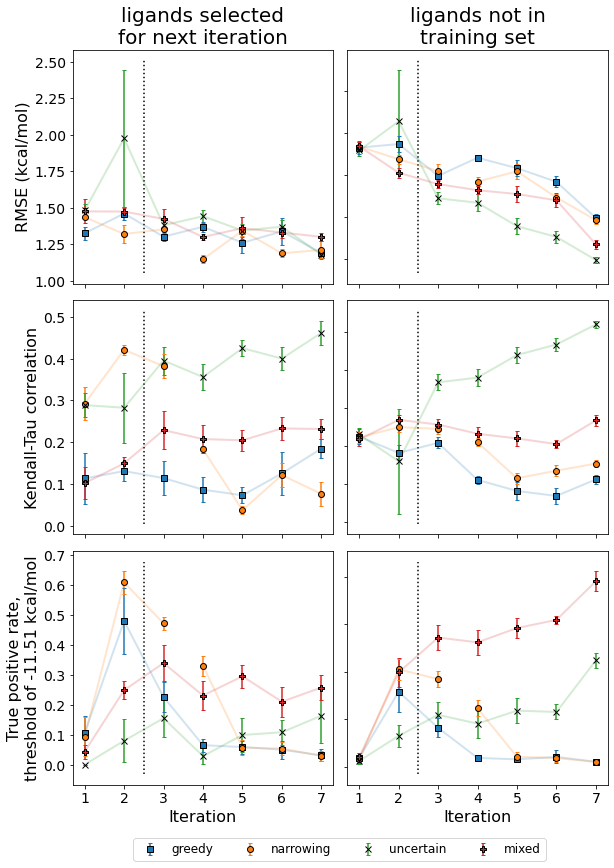

In [64]:
import matplotlib.ticker as ticker
pgroups=["RMSD", "KT", "TP"]
labels=["RMSE (kcal/mol)", "Kendall-Tau correlation", "True positive rate,\nthreshold of -11.51 kcal/mol"]
dgroups=["selected", "unmeasured"]
titles=["ligands selected\nfor next iteration", "ligands not in\ntraining set"]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

# x=np.arange(len(run_mean_hist_by_sele_method[0].RMSD_XVal))
# x=100*7*(x+1)/2351 # convert to percent

n_sub_plots=len(pgroups)
fig, axs = plt.subplots(n_sub_plots, len(dgroups), figsize=[1.2*len(dgroups)*3.6, 1.2*n_sub_plots*3.6], facecolor='w')
for sp in range(n_sub_plots):
    for sd in range(len(dgroups)):
        plt.sca(axs[sp,sd])
        plt.xlabel("Iteration", size=16)
        plt.ylabel(labels[sp], size=16)
        axs[sp,sd].xaxis.set_major_locator(ticker.MultipleLocator(1))
        #plt.title(labels[sp]+" ligands", size=18)

        plt.tick_params(axis='x', labelsize=14 )
        plt.tick_params(axis='y', labelsize=14 )

        if(sd!=0):
            axs[sp,sd].axes.yaxis.set_ticklabels([])
            axs[sp,sd].set_ylabel("")
            
        if(sp!=n_sub_plots-1):
            axs[sp,sd].axes.xaxis.set_ticklabels([])
            axs[sp,sd].set_xlabel("")
            
        if(sp==0):
            plt.title(titles[sd], size=20)
            


        for cnum in range(len(sele_method_names)):
            lbl=sele_method_names[cnum]
            if(lbl=="random"):
                continue;
            atrname=pgroups[sp]+"_"+dgroups[sd]
            y_avg=getattr(run_mean_hist_by_sele_method[cnum], atrname)
            y_sem=getattr(run_mean_hist_by_sele_method[cnum], atrname+"_err")
            
            #print(atrname, len(x), len(y_avg))

            x=np.arange(7)+1

            ls="solid"
            lw=2
            if(lbl=="schroedinger"):
                #lbl="Schrödinger"
                lbl="mixed"

            if(lbl=="narrowing"):
                lbl="narrowing"
                plt.plot(x[:3], y_avg[:3], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
                plt.plot(x[3:], y_avg[3:], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
                plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                             marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
            else:
                plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
                plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                             marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

        xlim=plt.gca().get_xlim()

        ylim=plt.gca().get_ylim()
        plt.vlines(2.5, ylim[0], ylim[1], colors="black", linestyles='dotted')
        plt.gca().set_xlim((xlim[0],xlim[1]))

        
#     pad=3
#     axs[sd,0].annotate(dgroups[sd],
#                 xy=(0, 0.5), xytext=(-axs[sd,0].yaxis.labelpad - pad, 0),
#                 xycoords=axs[sd,0].yaxis.label, textcoords='offset points',
#                 size='large', ha='right', va='center')

#plt.suptitle("Convergence metrics for top 50 strongest binding ligands", size=20)
plt.tight_layout(rect=[0, 0.1, 1, 1])

#axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=4)
axs[2,1].legend(loc='lower center', bbox_to_anchor=(-0.03, -0.35), ncol=5, prop={'size': 12})

plt.savefig(f"sele_method_accuracy.png",
                dpi='figure',
                facecolor='w'
               )
plt.show()

# repeateability with different selection rules

In [47]:
with open(all_ligs_db_file, 'rb') as f:
    all_ligs = pickle.load(f)
    
dGs=np.array([float(lig.GetProp('dG')) for lig in all_ligs])

In [48]:
def bootstrap_pairs(pairs, func, reps=1000):
    results=np.zeros(reps)
    l=len(pairs)
    for i in range(reps):
        sample_indeces=np.random.choice(l, l, replace=True)
        samples=[pairs[j] for j in sample_indeces] # looks like argl to the func
        results[i]=func(samples)

    ret = np.std(results)
    return(ret)

def num_common_func(pairs):
    n_common=[]
    for i in range(len(pairs)):
        a=pairs[i][0]
        b=pairs[i][1]
        n_common.append(len(np.intersect1d(a,b)))
    return(np.mean(n_common))

### evaluated ligands

In [49]:
# load the repeats of the protocol

n_top_ligs=[10,20,30,40,50,60,70,80,90,100]
common_top_n_ligs=[]
common_top_n_ligs_err=[]

for sid in range(len(sele_method_sfiles)):   
    top_found_ids=[]
    for fn in sele_method_sfiles[sid]:
        with open(fn, 'rb') as f:
            learner_settings, learner_metrics = pickle.load(f)
            knowndGs=dGs[learner_metrics.known_lig_ids]
            best=learner_metrics.known_lig_ids[np.argsort(knowndGs)]
            top_ns_found_ids=[]
            for n in n_top_ligs:
                top_ns_found_ids.append(best[:n])
            top_found_ids.append(top_ns_found_ids)

    this_sele_top_n_common=[]
    this_sele_top_n_common_err=[]
    for n in range(len(n_top_ligs)):
        n_common=[]
        pairs=[]
        for i in range(len(sele_method_sfiles[sid])-1):
            for j in range(i,len(sele_method_sfiles[sid])):
                a=top_found_ids[i][n]
                b=top_found_ids[j][n]
                n_common.append(len(np.intersect1d(a,b)))
                pairs.append((a,b))

        this_sele_top_n_common.append(np.mean(n_common))
        this_sele_top_n_common_err.append( bootstrap_pairs(pairs, num_common_func) )
    common_top_n_ligs.append(np.array(this_sele_top_n_common))
    common_top_n_ligs_err.append(np.array(this_sele_top_n_common_err))

In [50]:
for i in range(len(sele_method_names)):
    print(f"{sele_method_names[i]:25s}:", end='')
    for n in range(len(n_top_ligs)):
        print(f"\t{common_top_n_ligs[i][n]/n_top_ligs[n]:.2f}+-{common_top_n_ligs_err[i][n]/n_top_ligs[n]:.2f}", end='')
    print()

greedy                   :	1.00+-0.00	1.00+-0.00	0.99+-0.00	0.98+-0.00	0.99+-0.00	0.98+-0.00	0.97+-0.01	0.99+-0.00	0.98+-0.00	0.98+-0.00
narrowing                :	1.00+-0.00	1.00+-0.00	0.99+-0.00	0.99+-0.00	0.99+-0.00	0.98+-0.00	0.97+-0.01	0.99+-0.00	0.98+-0.00	0.98+-0.00
uncertain                :	0.54+-0.09	0.53+-0.08	0.54+-0.08	0.53+-0.08	0.54+-0.08	0.53+-0.08	0.53+-0.08	0.53+-0.08	0.54+-0.08	0.54+-0.08
schroedinger             :	0.74+-0.05	0.78+-0.04	0.81+-0.03	0.84+-0.03	0.84+-0.03	0.85+-0.03	0.85+-0.03	0.85+-0.03	0.86+-0.03	0.86+-0.02
random                   :	0.53+-0.09	0.51+-0.09	0.53+-0.08	0.52+-0.08	0.52+-0.08	0.52+-0.08	0.51+-0.08	0.52+-0.08	0.53+-0.08	0.53+-0.08


In [51]:
# load the repeats of the protocol

iterations=np.arange(7)
common_top_it_ligs=[]
common_top_it_ligs_err=[]

n=50
for sid in range(len(sele_method_sfiles)):   
    top_found_ids=[]
    for fn in sele_method_sfiles[sid]:
        with open(fn, 'rb') as f:
            learner_settings, learner_metrics = pickle.load(f)
            
            top_its_found_ids={}
            known_at_this_iter=learner_metrics.known_lig_ids
            for it in np.flip(iterations):
                knowndGs=dGs[known_at_this_iter]
                best=known_at_this_iter[np.argsort(knowndGs)]
                top_its_found_ids[it]=best[:n]
                # update known
                known_at_this_iter=np.array([i for i in known_at_this_iter if not i in learner_metrics.step_lig_ids[it]])
            top_found_ids.append(top_its_found_ids)


    this_sele_top_it_common=[]
    this_sele_top_it_common_err=[]
    for it in iterations:
        n_common=[]
        pairs=[]
        for i in range(len(sele_method_sfiles[sid])-1):
            for j in range(i,len(sele_method_sfiles[sid])):
                a=top_found_ids[i][it]
                b=top_found_ids[j][it]
                n_common.append(len(np.intersect1d(a,b)))
                pairs.append((a,b))

        this_sele_top_it_common.append(np.mean(n_common))
        this_sele_top_it_common_err.append( bootstrap_pairs(pairs, num_common_func) )
    common_top_it_ligs.append(np.array(this_sele_top_it_common))
    common_top_it_ligs_err.append(np.array(this_sele_top_it_common_err))
    #raise()

In [52]:
print(f"{'':25s}", end='')
for it in iterations:
    print(f"\t{it:^10d}", end='')
print()
for i in range(len(sele_method_names)):
    print(f"{sele_method_names[i]:25s}:", end='')
    for it in iterations:
        print(f"\t{common_top_it_ligs[i][it]/n:.2f}+-{common_top_it_ligs_err[i][it]/n:.2f}", end='')
    print()

                         	    0     	    1     	    2     	    3     	    4     	    5     	    6     
greedy                   :	0.42+-0.10	0.58+-0.07	0.81+-0.03	0.90+-0.02	0.92+-0.02	0.96+-0.01	0.99+-0.00
narrowing                :	0.44+-0.10	0.60+-0.07	0.73+-0.05	0.88+-0.02	0.93+-0.01	0.96+-0.01	0.99+-0.00
uncertain                :	0.34+-0.11	0.38+-0.10	0.38+-0.10	0.41+-0.10	0.45+-0.09	0.48+-0.09	0.54+-0.08
schroedinger             :	0.36+-0.11	0.44+-0.09	0.58+-0.08	0.67+-0.06	0.76+-0.04	0.82+-0.03	0.84+-0.03
random                   :	0.35+-0.11	0.36+-0.11	0.41+-0.10	0.43+-0.10	0.46+-0.09	0.49+-0.08	0.52+-0.08


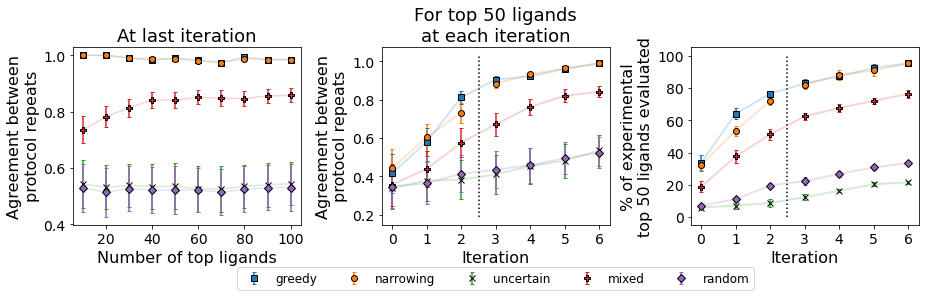

In [62]:
import matplotlib.ticker as ticker
titles=["ligands selected\nfor next iteration", "ligands not in\ntraining set"]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

n_sub_plots=3
fig, axs = plt.subplots(1, n_sub_plots, figsize=[1.2*n_sub_plots*3.6, 1.2*1*3.6], facecolor='w')


# vs n
plt.sca(axs[0])
plt.xlabel("Number of top ligands", size=16)
plt.ylabel("Agreement between\nprotocol repeats", size=16)
plt.title("At last iteration", size=18)

plt.tick_params(axis='x', labelsize=14 )
plt.tick_params(axis='y', labelsize=14 )
    
for cnum in range(len(sele_method_names)):
    lbl=sele_method_names[cnum] # repr_method_names[cnum]
    y_avg=common_top_n_ligs[cnum]/np.array(n_top_ligs)
    y_sem=common_top_n_ligs_err[cnum]/np.array(n_top_ligs)

    x=n_top_ligs

    ls="solid"
    lw=1.5

    plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
    plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                 marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()
    
    
    
# vs it
plt.sca(axs[1])
plt.xlabel("Iteration", size=16)
plt.ylabel("Agreement between\nprotocol repeats", size=16)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title("For top 50 ligands\nat each iteration", size=18)

plt.tick_params(axis='x', labelsize=14 )
plt.tick_params(axis='y', labelsize=14 )

#plt.gca().axes.yaxis.set_ticklabels([])
#plt.gca().set_ylabel("")


for cnum in range(len(sele_method_names)):
    lbl=sele_method_names[cnum]
    y_avg=common_top_it_ligs[cnum]/50.
    y_sem=common_top_it_ligs_err[cnum]/50.

    x=np.arange(7)

    ls="solid"
    lw=2
    if(lbl=="schroedinger"):
        lbl="mixed"

    if(lbl=="narrowing"):
        lbl="narrowing"
        plt.plot(x[:3], y_avg[:3], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
        plt.plot(x[3:], y_avg[3:], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
        plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                     marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
    else:
        plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
        plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                     marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

xlim=plt.gca().get_xlim()
ylim=plt.gca().get_ylim()
plt.vlines(2.5, ylim[0], ylim[1], colors="black", linestyles='dotted')
plt.gca().set_xlim((min(0,xlim[0]),xlim[1]))




# num found vs it
plt.sca(axs[2])
plt.xlabel("Iteration", size=16)
plt.ylabel("% of experimental\ntop 50 ligands evaluated", size=16)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
#plt.title("For top 50 ligands\nat each iteration", size=18)

plt.tick_params(axis='x', labelsize=14 )
plt.tick_params(axis='y', labelsize=14 )

# plt.gca().axes.yaxis.set_ticklabels([])
# plt.gca().set_ylabel("")


for cnum in range(len(sele_method_names)):
    lbl=sele_method_names[cnum] # repr_method_names[cnum]   
    atrname="top50_found"
    y_avg=getattr(run_mean_hist_by_sele_method[cnum], atrname)*100.0/50
    y_sem=getattr(run_mean_hist_by_sele_method[cnum], atrname+"_err")*100.0/50

    x=np.arange(7)

    ls="solid"
    lw=2
    if(lbl=="schroedinger"):
        lbl="mixed"

    if(lbl=="narrowing"):
        lbl="narrowing"
        plt.plot(x[:3], y_avg[:3], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
        plt.plot(x[3:], y_avg[3:], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
        plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                     marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
    else:
        plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
        plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                     marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
    
xlim=plt.gca().get_xlim()
ylim=plt.gca().get_ylim()
plt.vlines(2.5, ylim[0], ylim[1], colors="black", linestyles='dotted')
plt.gca().set_xlim((min(0,xlim[0]),xlim[1]))



#plt.suptitle("Convergence metrics for top 50 strongest binding ligands", size=20)
plt.tight_layout(rect=[0, 0.1, 1, 1])

#axs[1].legend(loc='lower center', bbox_to_anchor=(-0.03, -0.40), ncol=5, prop={'size': 12})
axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.40), ncol=5, prop={'size': 12})

plt.savefig(f"sele_agreement.png",
                dpi='figure',
                facecolor='w'
               )
plt.show()

### predicted ligands

In [55]:
n_top_ligs=[10,20,30,40,50,60,70,80,90,100]
common_pred_top_n_ligs=[]
common_pred_top_n_ligs_err=[]
for sid in range(len(sele_method_sfiles)):
    
    top_pred_ids=[]
    nrepeats=len(P_per_sele[sid])
    for repeat in range(nrepeats):
        P=P_per_sele[sid][repeat][-1] # at last iter
        best=np.argsort(P)
        top_ns_pred_ids=[]
        for n in n_top_ligs:
            top_ns_pred_ids.append(best[:n])
        top_pred_ids.append(top_ns_pred_ids)

    this_repr_top_n_pred_common=[]
    this_repr_top_n_pred_common_err=[]
    for n in range(len(n_top_ligs)):
        n_common=[]
        pairs=[]
        for i in range(nrepeats-1):
            for j in range(i,nrepeats):
                a=top_pred_ids[i][n]
                b=top_pred_ids[j][n]
                n_common.append(len(np.intersect1d(a,b)))
                pairs.append((a,b))

        this_repr_top_n_pred_common.append(np.mean(n_common))
        #this_repr_top_n_common_err.append(np.std(n_common))
        this_repr_top_n_pred_common_err.append( bootstrap_pairs(pairs, num_common_func) )
    common_pred_top_n_ligs.append(np.array(this_repr_top_n_pred_common))
    common_pred_top_n_ligs_err.append(np.array(this_repr_top_n_pred_common_err))

In [56]:
# load the repeats of the protocol

iterations=np.arange(7)
common_top_pred_it_ligs=[]
common_top_pred_it_ligs_err=[]

n=50
for sid in range(len(sele_method_sfiles)):
    top_pred_ids=[]
    nrepeats=len(P_per_sele[sid])
    for repeat in range(nrepeats):
        top_its_pred_ids={}
        for it in iterations:
            P=P_per_sele[sid][repeat][it] # at last iter
            best=np.argsort(P)
            top_its_pred_ids[it]=best[:n]
        top_pred_ids.append(top_its_pred_ids)

    this_sele_top_it_pred_common=[]
    this_sele_top_it_pred_common_err=[]
    for it in iterations:
        n_common=[]
        pairs=[]
        for i in range(nrepeats-1):
            for j in range(i,nrepeats):
                a=top_pred_ids[i][it]
                b=top_pred_ids[j][it]
                n_common.append(len(np.intersect1d(a,b)))
                pairs.append((a,b))

        this_sele_top_it_pred_common.append(np.mean(n_common))
        this_sele_top_it_pred_common_err.append( bootstrap_pairs(pairs, num_common_func) )
    common_top_pred_it_ligs.append(np.array(this_sele_top_it_pred_common))
    common_top_pred_it_ligs_err.append(np.array(this_sele_top_it_pred_common_err))
    #raise()

In [57]:
print(f"{'':25s}", end='')
for it in iterations:
    print(f"\t{it:^10d}", end='')
print()
for i in range(len(sele_method_names)):
    print(f"{sele_method_names[i]:25s}:", end='')
    for it in iterations:
        print(f"\t{common_top_pred_it_ligs[i][it]/n:.2f}+-{common_top_pred_it_ligs_err[i][it]/n:.2f}", end='')
    print()

                         	    0     	    1     	    2     	    3     	    4     	    5     	    6     
greedy                   :	0.45+-0.10	0.64+-0.06	0.81+-0.03	0.87+-0.03	0.90+-0.02	0.89+-0.02	0.92+-0.01
narrowing                :	0.46+-0.09	0.58+-0.07	0.71+-0.05	0.86+-0.02	0.87+-0.02	0.91+-0.02	0.90+-0.02
uncertain                :	0.45+-0.09	0.45+-0.09	0.47+-0.09	0.47+-0.09	0.48+-0.09	0.52+-0.08	0.55+-0.08
schroedinger             :	0.45+-0.10	0.52+-0.08	0.66+-0.06	0.69+-0.05	0.74+-0.04	0.80+-0.03	0.87+-0.02
random                   :	0.46+-0.09	0.51+-0.08	0.57+-0.07	0.58+-0.07	0.61+-0.07	0.62+-0.07	0.65+-0.06


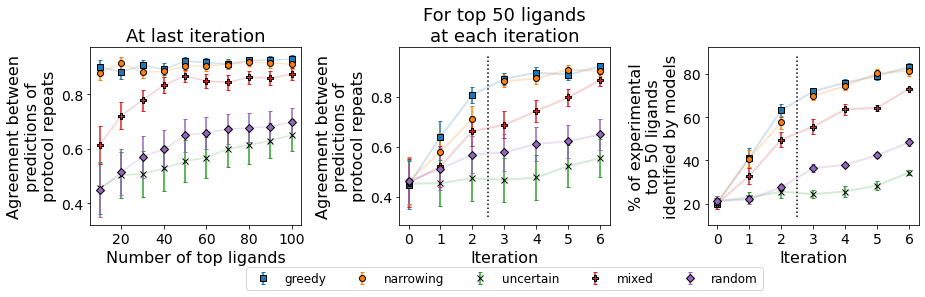

In [61]:
import matplotlib.ticker as ticker
titles=["ligands selected\nfor next iteration", "ligands not in\ntraining set"]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.2

n_sub_plots=3
fig, axs = plt.subplots(1, n_sub_plots, figsize=[1.2*n_sub_plots*3.6, 1.2*1*3.6], facecolor='w')


# vs n
plt.sca(axs[0])
plt.xlabel("Number of top ligands", size=16)
plt.ylabel("Agreement between\npredictions of\nprotocol repeats", size=16)
plt.title("At last iteration", size=18)

plt.tick_params(axis='x', labelsize=14 )
plt.tick_params(axis='y', labelsize=14 )
    
for cnum in range(len(sele_method_names)):
    lbl=sele_method_names[cnum] # repr_method_names[cnum]
    y_avg=common_pred_top_n_ligs[cnum]/np.array(n_top_ligs)
    y_sem=common_pred_top_n_ligs_err[cnum]/np.array(n_top_ligs)

    x=n_top_ligs

    ls="solid"
    lw=1.5

    plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
    plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                 marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()
    
    
    
# vs it
plt.sca(axs[1])
plt.xlabel("Iteration", size=16)
plt.ylabel("Agreement between\npredictions of\nprotocol repeats", size=16)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title("For top 50 ligands\nat each iteration", size=18)

plt.tick_params(axis='x', labelsize=14 )
plt.tick_params(axis='y', labelsize=14 )

#plt.gca().axes.yaxis.set_ticklabels([])
#plt.gca().set_ylabel("")


for cnum in range(len(sele_method_names)):
    lbl=sele_method_names[cnum]
    y_avg=common_top_pred_it_ligs[cnum]/50.
    y_sem=common_top_pred_it_ligs_err[cnum]/50.

    x=np.arange(7)

    ls="solid"
    lw=2
    if(lbl=="schroedinger"):
        lbl="mixed"

    if(lbl=="narrowing"):
        lbl="narrowing"
        plt.plot(x[:3], y_avg[:3], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
        plt.plot(x[3:], y_avg[3:], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
        plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                     marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
    else:
        plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
        plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                     marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

xlim=plt.gca().get_xlim()
ylim=plt.gca().get_ylim()
plt.vlines(2.5, ylim[0], ylim[1], colors="black", linestyles='dotted')
plt.gca().set_xlim((min(0,xlim[0]),xlim[1]))




# num found vs it
plt.sca(axs[2])
plt.xlabel("Iteration", size=16)
plt.ylabel("% of experimental\ntop 50 ligands\nidentified by models", size=16)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
#plt.title("For top 50 ligands\nat each iteration", size=18)

plt.tick_params(axis='x', labelsize=14 )
plt.tick_params(axis='y', labelsize=14 )

# plt.gca().axes.yaxis.set_ticklabels([])
# plt.gca().set_ylabel("")


for cnum in range(len(sele_method_names)):
    lbl=sele_method_names[cnum] # repr_method_names[cnum]   
    #atrname="top50_found"
    atrname="top50_correctly_predicted"
    y_avg=getattr(run_mean_hist_by_sele_method[cnum], atrname)*100.0/50
    y_sem=getattr(run_mean_hist_by_sele_method[cnum], atrname+"_err")*100.0/50

    x=np.arange(7)

    ls="solid"
    lw=2
    if(lbl=="schroedinger"):
        lbl="mixed"

    if(lbl=="narrowing"):
        lbl="narrowing"
        plt.plot(x[:3], y_avg[:3], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
        plt.plot(x[3:], y_avg[3:], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
        plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                     marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
    else:
        plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
        plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                     marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
    
xlim=plt.gca().get_xlim()
ylim=plt.gca().get_ylim()
plt.vlines(2.5, ylim[0], ylim[1], colors="black", linestyles='dotted')
plt.gca().set_xlim((min(0,xlim[0]),xlim[1]))



#plt.suptitle("Convergence metrics for top 50 strongest binding ligands", size=20)
plt.tight_layout(rect=[0, 0.1, 1, 1])

#axs[1].legend(loc='lower center', bbox_to_anchor=(-0.03, -0.40), ncol=5, prop={'size': 12})
axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.40), ncol=5, prop={'size': 12})

plt.savefig(f"sele_agreement_v2.png",
                dpi='figure',
                facecolor='w'
               )
plt.show()

# Check greedy without IFV

In [ ]:
normalize_x=True
shuffle_seed=12345678

#n_Epochs=2000
#hl_w=300
#hl_depth=2

n_Epochs=200
hl_w=20
hl_depth=1

init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

#weighted=True
weighted=False
use_dropout=True
shiftY=True

redo=False

sele_rules=[
    SelectionRule.greedy,
    SelectionRule.narrowing,
#     SelectionRule.uncertain,
#     SelectionRule.schroedinger,
#     SelectionRule.random
]

n_picks_per_step=100

run_name_prefixes=[
    f"sele_rule_greedy",
    f"metaparams_as_in_prospective",
#     f"sele_rule_uncertain",
#     f"sele_rule_schroedinger",
#     f"sele_rule_random"
]

sele_method_sfiles_no_IFV=[]

starting_method=StartingSelectionMethod.weighted_by_2D_repr

learner_settings_folder=f"{experiment_folder}/AL_settings"
os.makedirs(learner_settings_folder, exist_ok=True)

hl_w='auto'
hl_depth='auto'
n_Epochs='auto'



counter=0
unfinished=[]

repeats_fnames=[]
repeats_logfns=[]
for rule_id in range(len(sele_rules)):
    this_sele_method_sfiles=[]
    for r in range(5):
        run_name=f"{run_name_prefixes[rule_id]}_no_IFV_repeat_{r}"
        sele_rule=sele_rules[rule_id]
        starting_ligs_seed=123456+r
        learner_settings=[
            normalize_x, shuffle_seed, n_Epochs, init_learning_rate, learning_rate_decay, weight_decay,
            impfilt, X_filter, weighted, shiftY, use_dropout, sele_rule, starting_method, hl_w, hl_depth,
            starting_ligs_seed,n_picks_per_step,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,run_name
        ]

        sha = hashlib.sha256()
        sha.update(pickle.dumps(learner_settings))
        #settings_hash=dr_name+"_"+sha.hexdigest()[:10]
        #settings_fname=f"{learner_settings_folder}/learner_settings_repr_{settings_hash}.pickle"
        settings_hash=sha.hexdigest()[:6]

        settings_fname=f"{learner_settings_folder}/learner_settings_{run_name}_{settings_hash}.pickle"
        if(os.path.exists(settings_fname)):
            with open(settings_fname, 'rb') as f:
                settings_loaded, learner_metrics = pickle.load(f)
                if(learner_metrics is not None and not redo):
                    if(len(learner_metrics.top10_found)<7):
                        print(f"{settings_fname} has started but is not finished.")
                        unfinished.append(counter)
                    else:
#                         print(f"{settings_fname} has finished.")
                        pass
                else:
                    print(f"{settings_fname} exists but is not trained yet.")
                    unfinished.append(counter)
        else:
#             pickle.dump( (learner_settings, None), open( settings_fname, "wb" ) )
            print(f"{settings_fname} written.")
            unfinished.append(counter)

        repeats_fnames.append(settings_fname)

        os.makedirs(f"{learner_settings_folder}/run_{settings_hash}/", exist_ok=True)
        repeats_logfns.append(f"{learner_settings_folder}/run_{settings_hash}/run_{settings_hash}.log")
        this_sele_method_sfiles.append(settings_fname)
#         print(settings_fname)
        counter+=1
    sele_method_sfiles_no_IFV.append(this_sele_method_sfiles)

In [ ]:
if 'custom_dataset_modular_with_binning_6EZF' in sys.modules:
    importlib.reload(sys.modules['custom_dataset_modular_with_binning_6EZF'])
else:
    import custom_dataset_modular_with_binning_6EZF
from custom_dataset_modular_with_binning_6EZF import dataBlocks, CustomMolModularDataset

if 'NNs' in sys.modules:
    importlib.reload(sys.modules['NNs'])
else:
    import NNs
from NNs import *

if 'owl_trainer_w_params_general_with_ensemble_summary_model_6EZF' in sys.modules:
    importlib.reload(sys.modules['owl_trainer_w_params_general_with_ensemble_summary_model_6EZF'])
else:
    import owl_trainer_w_params_general_with_ensemble_summary_model_6EZF
from owl_trainer_w_params_general_with_ensemble_summary_model_6EZF import *

if 'active_learner_6EZF' in sys.modules:
    importlib.reload(sys.modules['active_learner_6EZF'])
else:
    import active_learner_6EZF
from active_learner_6EZF import *

In [ ]:
class redirect_output(object):
    """context manager for reditrecting stdout/err to files"""


    def __init__(self, stdout='', stderr=''):
        self.stdout = stdout
        self.stderr = stderr

    def __enter__(self):
        self.sys_stdout = sys.stdout
        self.sys_stderr = sys.stderr

        if self.stdout:
            sys.stdout = open(self.stdout, 'w')
        if self.stderr:
            if self.stderr == self.stdout:
                sys.stderr = sys.stdout
            else:
                sys.stderr = open(self.stderr, 'w')

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout = self.sys_stdout
        sys.stderr = self.sys_stderr

In [ ]:
from multiprocessing import Process, Queue, Pool, TimeoutError, Lock
import dill

global mp_lock;
mp_lock = Lock()

def run_dill_encoded(payload):
    fun, args = dill.loads(payload)
    return fun(*args)
# def my_pool_apply_async(pool, fun, args):
#     payload = dill.dumps((fun, args))
#     return pool.apply_async(run_dill_encoded, (payload,))
def my_pool_map(pool, fun, args_list):
    payloads = [dill.dumps((fun, [arg])) for arg in args_list]
    return pool.map(run_dill_encoded, payloads)

def run_AL_single(A):
    settings_fname, logfn=A
    with redirect_output(logfn):
        #print(settings_fname, logfn)
        #AL_Trainer(settings_fname, all_ligs_db_file, redo=False, verbose=True)
        all_ligs_db_file_cluster=f"{energy_folder}/full_ligs.pickle"
        AL_Trainer(settings_fname, all_ligs_db_file_cluster, redo=True, verbose=True,
                   use_moa=False)



args=list(zip(repeats_fnames,repeats_logfns))
args=[args[i] for i in unfinished]
# args=list(zip(repeats_info_random[0],repeats_info_random[1]))
with Pool(processes=len(args), initargs=(mp_lock,)) as pool:
    my_pool_map(pool, run_AL_single, args)